***
# Classification
MSDS 7331-407, Lab 2 
*Jenna Ford, Edward Fry, Christian Nava, and Jonathan Tan* 
***

<a id = 'Section_0'></a>

## Table of Contents

<a href='#Section_1'> 1. Introduction </a>  
<a href='#Section_2'> 2. Preparation and Dataset Loading </a>  
<a href='#Section_3'> 3. Data Preparation Part 1 </a>  
<a href='#Section_4'> 4. Data Preparation Part 2 </a>  
<a href='#Section_5'> 5. Metrics </a>  
<a href='#Section_6'> 6. Cross Validation </a>  
<a href='#Section_7'> 7. Models </a>  
<a href='#Section_7_a'> &nbsp;&nbsp;&nbsp;&nbsp; a. Arrest Type Code </a>  
<a href='#Section_7_a_1'> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (1). LightGBM </a>  
<a href='#Section_7_a_2'> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (2). XGBoost </a>  
<a href='#Section_7_a_3'> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (3). Random Forest </a>  
<a href='#Section_7_a_4'> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (4). Support Vector Machine </a>  
<a href='#Section_7_b'> &nbsp;&nbsp;&nbsp;&nbsp; b. Descent Code </a>  
<a href='#Section_7_b_1'> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (1). LightGBM </a>  
<a href='#Section_7_b_2'> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (2). XGBoost </a>  
<a href='#Section_7_b_3'> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (3). Random Forest </a>  
<a href='#Section_7_b_4'> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (4). Support Vector Machine </a>  
<a href='#Section_8'> 8. AUC Plot </a>  
<a href='#Section_9'> 9. Model Comparison </a>  
<a href='#Section_10'> 10. Important Variables </a>  
<a href='#Section_11'> 11. Deployment </a>  
<a href='#Section_12'> 12. Additional Analysis </a>  

<!-- <a href='#Section_4_c_i'> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; i. Cross Street </a>    --> 

<a id = 'Section_1'></a>

## 1. Introduction

For this project our group will continue to use the Los Angeles arrest incidents dataset with arrest incidents dating back to 2010, which can be found [here](https://data.lacity.org/A-Safe-City/Arrest-Data-from-2010-to-Present/yru6-6re4). This dataset contains information about the date, time and location of the incident, demographic data of the person arrested, and information about the type of incident.

We will be classifying the variables `Arrest Type Code` (Felony, Misdemeanor, Infraction, Other) and `Descent Code` (Black, Hispanic, White, Other). We feel that being able to classify arrest type could help in prioritizing dispatch calls, especially when there are more calls than officers available to respond. We assume that arrest type is generally an indicator of the severity of the incident. It is also worth noting that most of the data available for the classification would be available to the dispatcher. For example, someone placing a call to 911 would most likely have a basic description of the offender such as gender, approximate age and ethnicity. The caller would also know the location of the incident and have a brief description of the situation. Additional domain knowledge from a law enforcement perspective might have further applications for arrest type classifications, from future forecasts to retrospective analysis.

As far as classifying `Descent Code`, we are not trying to make any political statements. The dataset is only able to give a general picture of an arrestee's broadest ethnic classification. However, if this variable can be predicted with confidence, trends and the patterns governing them can be identified. Relations between arrest trends and various ethnicities can be valuable information about how these ethnicities interact with the law. Verifiable data pointing to higher or lower rates of specific crimes for certain ethnicities might be used to isolate trends from bias and perhaps better identify causes or direct change.

Both of these categories are small steps towards a more complete understanding of larger sociological forces. Observations such as patterns in arrest data could help form a more complete understanding of Los Angeles county and its citizens. Being able to identify how different sociological enclaves are affected by Los Angeles law enforcement would be particularly useful in evaluating the efficacy of a myriad of institutional elements of society, such as support services, zoning laws, social programs, economic stimuli, corporate campaigns, administrative changes, or even macroscopic societal trends.

We use 10-fold cross validation to test a variety of models in order to compensate for highly unbalanced data in both `Arrest Type` and `Descent Code` and to prevent overfitting. Even at on a 2.6% sample of the total dataset, 31,094 datapoints are still in play. We also adjust model parameters to fine-tune our classification models.

AUC score was chosen as the primary evaluation metric instead of accuracy due to the imbalanced nature of the dataset. In most categories the datapoints are concentrated in certain categories; arrest type code is mostly misdemeanors and descent code pluralistically Hispanic. Simple accuracy ratings might skew decisions in favor of models that discard precision for recall by over generalizing to fit the biggest trend. AUC scoring allows precision to be balanced with recall and ensure that the overall number of true positives generated by a model are not compromised by an excess of false positives. For both classification tasks, the ability of the model to distinguish between potential classes by balancing both precision and recall is a priority, as deficiency in either severely limits the potential uses of a model. Due to constraints on both the available data and computation time, we will consider models with AUC above 75% successful.

<a id = 'Section_2'></a>

## 2. Preparation and Dataset Loading

In [147]:
# Time the run
import time
startTime = time.time()

# Data manipulation
import numpy as np
import pandas as pd

# Creating training and test sets
import sklearn

# File system management
import os.path
from multiprocessing import Process
processes = []

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

#training/test split
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, ShuffleSplit

# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline

# here we can change some of the parameters interactively
from ipywidgets import widgets as wd
from sklearn.model_selection import cross_val_score, cross_validate

#for weights standardization
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report

from matplotlib import pyplot as plt

# Support vector machines
from sklearn.svm import SVC

import plotly
plotly.offline.init_notebook_mode() # run at the start of every notebook

In [148]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

In [149]:
# Constants
DATAPATH_BASE = 'https://machinelearningi.blob.core.windows.net/group-project/'
DATAPATH_SAS_TOKEN = '?sv=2019-02-02&ss=bfqt&srt=sco&sp=rwdlacup&se=2020-04-27T11:12:37Z&st=2020-01-23T04:12:37Z&spr=https&sig=jpIpjrp8dIg9eyUyPpmgTe5yj9i1ZoCSru5kBVHcUO8%3D'
DATAPATH_FILENAME = 'Arrest_Data_from_2010_to_Present.csv'
DATAPATH_SMALL_FILENAME = 'Arrest_Data_from_2010_to_Present_Small.csv'

# Performance controls
SUB_SAMPLE_SIZE = 0.026  #subsample of dataframe
SVM_SUB_SAMPLE_SIZE = .026 #subsample for SVM, don't go past 15% of the data because it won't run

#The following performance controls enabled us to easily split the load onto multiple computes
RUN_LGB1 = False
RUN_LGB2 = False
RUN_XGB1 = False
RUN_XGB2 = False
RUN_RF1 = False
RUN_RF2 = False
RUN_RF3 = False
RUN_RF4 = False
RUN_SVM1 = False
RUN_SVM2 = False
RUN_SVM3 = False
RUN_SVM4 = False
RUN_OTHER = False
RUN_EXTRA1 = False
RUN_EXTRA2 = False
RUN_EXTRA3 = False
RUN_EXTRA4 = False
RUN_EXTRA5 = False
RUN_EXTRA6 = False

# Fully qualified paths ready to use
DATA_SOURCE = "".join([DATAPATH_BASE, DATAPATH_FILENAME, DATAPATH_SAS_TOKEN])

# Options
pd.set_option('float_format', '{:.2f}'.format)  # Reign in the scientific notation for reasonable values

# Load data for analysis; only read if needed because the import can take a long time
try:
    if len(df.index) < 1:
        df_raw = pd.read_csv(DATA_SOURCE) # If we get here, the dataframe was empty
except:   
    df_raw = pd.read_csv(DATA_SOURCE) # If we get here, the dataframe did not exist
    

In [150]:
df = df_raw

print("The dataset has {:,} rows and {:,} columns".format(*df.shape))

The dataset has 1,326,626 rows and 17 columns


<a href='#Section_0'> Back to top </a>
<a id = 'Section_3'></a>

## 3. Data Preparation Part 1

The code below is from Lab 1 where we prepared the initial dataset. Here is a summary of the steps in the code below:
* Convert `Time` to a time format and treat missing values and a value of 24:00 as 00:00.
* Drop observations where the age of the individual is under 16. This is due to data issues (probably data entry errors).
* Drop observations where the `Arrest Type Code` is Dependent. The majority of these observations are for individuals aged 15 or less. Individuals under the age of 16 have already been removed from the dataset, however, there are some remaining observations with an `Arrest Type Code` of Dependent that we believe to be data entry errors.
* Reduce the `Descent Code` classifications to B-Black, H-Hispanic and W-White. All other ethnicities are grouped into O-Other.
* Create an `Hour` variable because knowing the hour and minute an incident occurred is not critical. A window of time will be more appropriate.
* Create variables for the day of week and month an incident occurred on. Knowing the exact date an incident occurred is not helpful for future classification, but day of week and month may be.
* Drop variables that are not useful for the analysis such as `Location` which has GIS coordinates and description variables that have an associated code variable.
* Adjust data types as needed.

In [151]:
# Time - filter out 0 and missing
df = df[df['Time'] != 0]
df['Time'] = df['Time'].astype(str) 
df = df[df['Time'] != 'nan']

# Time - Convert float to string. Get rid of decimals. Replace missing or invalid values with '0000'.
df['Time'] = df['Time'].astype(str).str.split(".", expand = True)[0].replace(to_replace = ['2400','nan'], value = '0000') 

# Time - Fill time column with leading zeros to have 4 characters total
df['Time'] = df['Time'].apply(lambda x: '{0:0>4}'.format(x))

# Time - Add colon to Time values by converting attribute to a datetime variable 
df['Time'] = pd.to_datetime(df['Time'], format = '%H%M').dt.time

# Charge Group Code - filter out missing values
df = df.loc[df['Charge Group Code'].notnull()]

# Age - Drop the observations where Age is less than 16
df.drop(df[df['Age'] < 16].index, inplace = True) 

# Arrest Type Code - Drop the observations where Arrest Type Code = 'D'
df.drop(df[df['Arrest Type Code'] == 'D'].index, inplace = True) 

# Descent Code - Re-classify any descent not in (B,H,O,W) into 0
descent_list = ['B','H','O','W']
df['Descent Code'] = np.where(np.isin(df['Descent Code'],descent_list),df['Descent Code'],'O')

# Get hour
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour

# Convert Arrest Date to datetime
df['Arrest Date'] = pd.to_datetime(df['Arrest Date'])

# Extract month, and day of week and add to dataframe as new attributes
df['arrest_month']= df['Arrest Date'].dt.month
try:
    df['arrest_day_of_week'] = df['Arrest Date'].dt.weekday_name
except:
    df['arrest_day_of_week'] = 'monday'

# remove unecessary columns
df.drop(['Cross Street','Charge Description','Charge','Charge Group Description','Time',
         'Arrest Date','Report ID','Address','Area Name','Location'], axis=1, inplace=True)

# Change data types
df['Age'] = df['Age'].astype(np.int8)
df['Reporting District'] = df['Reporting District'].astype(np.str)
df['Area ID'] = df['Area ID'].astype(np.str)
df['Charge Group Code'] = df['Charge Group Code'].astype(np.str)
df['Hour'] = df['Hour'].astype(np.str)
df['arrest_month'] = df['arrest_month'].astype(np.str)
df['arrest_day_of_week'] = df['arrest_day_of_week'].astype(np.str)

df_lightgbm = df
# print clean dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1195926 entries, 1 to 1326625
Data columns (total 10 columns):
Area ID               1195926 non-null object
Reporting District    1195926 non-null object
Age                   1195926 non-null int8
Sex Code              1195926 non-null object
Descent Code          1195926 non-null object
Charge Group Code     1195926 non-null object
Arrest Type Code      1195926 non-null object
Hour                  1195926 non-null object
arrest_month          1195926 non-null object
arrest_day_of_week    1195926 non-null object
dtypes: int8(1), object(9)
memory usage: 92.4+ MB


The code below prepares the dataset for classification tasks. First, we group `Age` into bins of 10 years and perform integer encoding, since the data is ordinal. Next, we perform one-hot encoding on all categorical variables. We use one-hot encoding here because no natural ordering exists in the values.

In [152]:
# Create buckets for Age
df['age_range'] = pd.cut(df.Age,[15,25,35,45,55,65,75,1e6],4,labels=[0,1,2,3,4,5,6]) # this creates a new variable
df['age_range'] = df['age_range'].fillna(0)
df['age_range'] = df.age_range.astype(np.int)

# Replace the current Sex atribute with something slightly more intuitive and readable
df['IsMale'] = df['Sex Code']=='M' 
df.IsMale = df.IsMale.astype(np.int)

# Perform one-hot encoding of the categorical data "DOW"
tmp_df = pd.get_dummies(df['arrest_day_of_week'],prefix='DOW',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Area ID"
tmp_df = pd.get_dummies(df['Area ID'],prefix='Area',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Charge Group Code"
tmp_df = pd.get_dummies(df['Charge Group Code'],prefix='Charge',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Hour"
tmp_df = pd.get_dummies(df['Hour'],prefix='Hour',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Month"
tmp_df = pd.get_dummies(df['arrest_month'],prefix='Month',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

Since we have 2 classification tasks (`Arrest Type Code` and `Descent Code`), we need 2 datasets. The dataset for classifying `Arrest Type Code` will need to have `Descent Code` one-hot encoded and the dataset for classifying `Descent Code` will need to have `Arrest Type Code` one-hot encoded.

The following 2 blocks of code print out information about each datset.

In [153]:
df_arrest = df
df_descent = df

#Final encoding steps for Arrest Type Code classification dataset
# Encode Arrest Type Code as Categorical
cleanup_arrest = {"Arrest Type Code": {"F": 0, "M": 1, "I": 2, "O":3}}
df_arrest.replace(cleanup_arrest,inplace=True)

# Perform one-hot encoding of the categorical data "Descent Code"
tmp_df = pd.get_dummies(df_arrest['Descent Code'],prefix='Descent',drop_first=True)
df_arrest = pd.concat((df_arrest,tmp_df),axis=1) # add back into the dataframe

df_arrest.drop(['Sex Code','Descent Code','arrest_day_of_week','Area ID','Reporting District','Charge Group Code',
         'Age','Hour','arrest_month'], axis=1, inplace=True)

df_arrest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1195926 entries, 1 to 1326625
Data columns (total 93 columns):
Arrest Type Code    1195926 non-null int64
age_range           1195926 non-null int32
IsMale              1195926 non-null int32
DOW_Monday          1195926 non-null uint8
DOW_Saturday        1195926 non-null uint8
DOW_Sunday          1195926 non-null uint8
DOW_Thursday        1195926 non-null uint8
DOW_Tuesday         1195926 non-null uint8
DOW_Wednesday       1195926 non-null uint8
Area_10             1195926 non-null uint8
Area_11             1195926 non-null uint8
Area_12             1195926 non-null uint8
Area_13             1195926 non-null uint8
Area_14             1195926 non-null uint8
Area_15             1195926 non-null uint8
Area_16             1195926 non-null uint8
Area_17             1195926 non-null uint8
Area_18             1195926 non-null uint8
Area_19             1195926 non-null uint8
Area_2              1195926 non-null uint8
Area_20             1195926

In [154]:
#Final encoding steps for Descent Code classification dataset
cleanup_descent = {"Descent Code": {"B": 0, "H": 1, "W": 2, "O":3}}
df_descent.replace(cleanup_descent,inplace=True)

# Perform one-hot encoding of the categorical data "Arrest Type Code"
tmp_df = pd.get_dummies(df_descent['Arrest Type Code'],prefix='Arrest',drop_first=True)
df_descent = pd.concat((df_descent,tmp_df),axis=1) #add back to the dataframe

df_descent.drop(['Sex Code','Arrest Type Code','arrest_day_of_week','Area ID','Reporting District','Charge Group Code',
         'Age','Hour','arrest_month'], axis=1, inplace=True)

df_descent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1195926 entries, 1 to 1326625
Data columns (total 93 columns):
Descent Code     1195926 non-null int64
age_range        1195926 non-null int32
IsMale           1195926 non-null int32
DOW_Monday       1195926 non-null uint8
DOW_Saturday     1195926 non-null uint8
DOW_Sunday       1195926 non-null uint8
DOW_Thursday     1195926 non-null uint8
DOW_Tuesday      1195926 non-null uint8
DOW_Wednesday    1195926 non-null uint8
Area_10          1195926 non-null uint8
Area_11          1195926 non-null uint8
Area_12          1195926 non-null uint8
Area_13          1195926 non-null uint8
Area_14          1195926 non-null uint8
Area_15          1195926 non-null uint8
Area_16          1195926 non-null uint8
Area_17          1195926 non-null uint8
Area_18          1195926 non-null uint8
Area_19          1195926 non-null uint8
Area_2           1195926 non-null uint8
Area_20          1195926 non-null uint8
Area_21          1195926 non-null uint8
Area_3 

In [155]:
print("The Arrest classification dataset set has {:,} rows and {:,} columns".format(*df_arrest.shape))
print("The Descent classification dataset set has {:,} rows and {:,} columns".format(*df_descent.shape))

The Arrest classification dataset set has 1,195,926 rows and 93 columns
The Descent classification dataset set has 1,195,926 rows and 93 columns


<a href='#Section_0'> Back to top </a>
<a id = 'Section_4'></a>

## 4. Data Preparation Part 2

A description of the final dataset can be found in the table below.

#### Table 1: Description of Final Dataset

| Dataset | Target/Explanatory| Variable | Variable Suffix Range | Description |
| :-- | :-- | :-- | :-- | :-- |
| Arrest | Target| Arrest Type Code | NA | Type of arrest incident. Felony=0, Misdemeanor=1, Infraction=2, Other=3 |  
| Arrest | Explanatory| Descent | B,H,W,O | Value of 1 indicates the descent of the individual. Descent_H: Hispanic, Descent_W: White and Descent_O: Other. |
| Descent | Target| Descent Code | NA | Ethnicity of person arrested. Black=0, Hispanic=1, White=2, Other=3 | 
| Descent | Explanatory| Arrest | 0-3 | Value of 1 indicates the type of arrest made. Arrest_1: Misdemeanor, Arrest2: Infraction and Arrest_3: Other. |
| Both | Explanatory| age_range | NA | Age of person arrested. Age bins: 16-25=0, 25-35=1, 35-45=2, 45-55=3, 55-65=4, 65-75=5, 75+=6|
| Both | Explanatory| IsMale | NA | Gender of person arrested. 0=Female, 1=Male|
| Both | Explanatory| DOW | Friday-Thursday | Value of 1 indicates the DOW the incident occurred on. |
| Both | Explanatory| Area | 1-21 | Value of 1 indicates the Area the incident occurred in. |
| Both | Explanatory| Charge | 1-29, 99, nan | Value of 1 indicates the Charge relating to the incident.|
| Both | Explanatory| Hour | 0-23 | Value of 1 indicates the Hour the incident occurred. |
| Both | Explanatory| Month | 1-12 | Value of 1 indicates the month the incident occurred. |

<a href='#Section_0'> Back to top </a>
<a id = 'Section_5'></a>

## 5. Metrics

The metric used for this project is the area under the Receiver Operating Characteristic curve (AUC). The Receiver Operating Characteristic curve (ROC) graphs the performance of a classification model at all classification thresholds; it plots the true positive rate (TPR) against the false positive rate (FPR) as shown in Figure 1.

<h4 align="center">Figure 1: Area Under the Reciever Operating Curve</h4> 
<img src="https://marlin-prod.literatumonline.com/cms/attachment/34661288-1f8f-459e-b8b4-936efc49e9bc/fx1_lrg.jpg" style="width:350px;height:300px"/>

Source: [Journal of Thoracic and Cardiovascular Surgery](https://www.jtcvs.org/article/S0022-5223(18)32875-7/fulltext)

Each curve represents the graph of a single model. Movement along the curve indicates changing the threshold used for classifying a positive instance. The area under the ROC curve measures the two-dimensional area under the ROC curve and is given by the integral of the curve, or the area under the curve (AUC): $$AUC = \int_{0}^{1}TPR(x)dx = \int_{0}^{1}P(A>\tau (x))dx$$

where $x$ is the false positive rate and $A$ is the distribution of scores the model produces for data points that are actually in the positive class.

This metric is measured between 0 and 1. A higher score indicates a better model. Visually, a superior model will graph as a curve above and to the left of another curve. A straight diagonal line beginning at 0 on the bottom left and ending at 1 on the top right indicates a naive model (random guessing). Other metrics such as accuracy are not the best metric for data with imbalanced classes. The Los Angeles City Arrest dataset is extremely imbalanced. 

A model with a high ROC AUC will also have a high accuracy, therefore, the AUC score will be the metric employed in this analysis.

We have choosen to use the micro-averaging method for averaging AUC, which averages the individual class's AUC by weight.

<a href='#Section_0'> Back to top </a>
<a id = 'Section_6'></a>

## 6. Cross Validation

Cross validation allows us to test our model on data it hasn't seen, to see how well the model performs when making predictions. Using cross validation can help identify if the model is overfitting the training data. If the model is overfitting the training data we would expect to see low evaluation metrics when predictions are created for the test dataset.

We use stratified 10-fold cross validation for this project. The classifiers we are using for this project are unbalanced. The first table below shows that 61% of arrests are Misdemeanors and only 2% of arrests are identified as Other. The second table below shows that 46% of arrests are for Hispanic individuals and 6% of arrests are for individuals grouped into an Other ethnicity bin. Balanced data would have approximately 25% of all arrests in each bucket (for both classifiers).

<a id = 'Section_7'></a>

In [10]:
#create a function to count by column and display percentages
def count_percent(data,field):
    df_grouped = data.groupby(by=field)
    c1 = (df_grouped[field].count())

    c2  = []#create empty list to store percentages
    for x in c1:
        c2.append("{:.2%}".format((x/sum(c1)))) #row value divided by total, formatted as percent, store in list
    c1 = pd.DataFrame(c1) #needs dataframe to start with, then can add new column from list c2
    c1['Percent']= c2
    c1.columns = ['Count','Percent']
    return c1

In [11]:
count_percent(df,'Arrest Type Code')

Count Percent
Arrest Type Code                
0                 411748  34.43%
1                 732097  61.22%
2                  26046   2.18%
3                  26035   2.18%

In [12]:
count_percent(df,'Descent Code')

Count Percent
Descent Code                
0             351070  29.36%
1             555027  46.41%
2             220781  18.46%
3              69048   5.77%

Due to having extremely unbalanced data it is important for us to use a cross validation technique that stratifies the sample, matching the same percentages of the classifier from the population dataset. This is the 'stratified' part of the stratified 10-fold cross validation tecnhique we have chosen. Without stratifying the folds we cannot ensure that the folds are representative of the population; leading to high bias and variance.

When splitting data into training and test datasets there is a concern that important patterns found in the data may be left out of the training dataset. If these patterns are not present in the training dataset the model won't be able to predict them in the test dataset. Using k-fold cross validation takes this into account. K-fold cross validation divides the data into k folds. K-1 folds are used to train the model and the remaining fold is used for testing. This is repeated for k-1 models and every fold is used for testing once. This reduces bias and variance since we are essentially using the entire dataset for training and testing. We have chosen 10-folds for our project, a typical value chosen.

<a href='#Section_0'> Back to top </a>
<a id = 'Section_7'></a>

## 7. Models

<a id = 'Section_7_a'></a>

In [156]:
df_arrest1 = df_arrest
df_descent1 = df_descent

#subsample of dataframe
df_arrest1 = pd.DataFrame.sample(df_arrest1, frac = SUB_SAMPLE_SIZE, random_state = 34128)
df_descent1 = pd.DataFrame.sample(df_descent1, frac = SUB_SAMPLE_SIZE, random_state = 34128)

print("The datasets have {:,} rows and {:,} columns".format(*df_arrest1.shape))

The datasets have 31,094 rows and 93 columns


### a. Arrest Type Code

In [157]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt


# create variables we are more familiar with
if 'Arrest Type Code' in df_arrest1:
    ya = df_arrest1['Arrest Type Code'].values # get the labels we want
    del df_arrest1['Arrest Type Code'] # get rid of the class label
    Xa = df_arrest1.values # use everything else to predict!
    
yhata = np.zeros(ya.shape) # we will fill this with predictions
yhata_score = np.zeros((ya.shape[0],4))

scl = StandardScaler()
Xa = scl.fit_transform(Xa)

# create cross validation iterator
cv = StratifiedKFold(n_splits=10, random_state=1234)

In [158]:
def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('0-Felony, 1-Misdemeanor, 2-Infraction, 3-Other')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()

<a href='#Section_0'> Back to top </a>
<a id = 'Section_7_a_1'></a>

### LightGBM - Arrest Type Code

The Gradient Boosting Machine algorithm is currently the leading model for learning on structured datasets. Gradient Boosting Machine will be implemented using the LightGBM library. LightGBM is a gradient-boosting framework that uses tree-based learning algorithms, or gradient boosted decision trees (GBDT).

Boositng is a sequential ensembling technique where instances that are hard to classify are given more weight (visualized as larger dots in Figure 3). This, in turn, allows subsequent learners to place more emphasis on learning the mis-classified data instances. Here, "learner" is used in the context to describe the program that builds a classifier.

<h4 align="center">Figure 3: Boosting</h4>
<img src="https://miro.medium.com/max/422/1*zFOpJUSU_zgg0FCPBOSXvg.png" style="width:300px;height:350px"/>

Image source: [QuantDare, "What is the difference between Bagging and Boosting?](https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/)

Gradient Boosted Decision Tree is a machine learning algorithm that sequentially trains decision trees. It is built over time by adding a new tree into the model that minimizes the error by previous learners. This is done by fitting the new tree on the residual errors of the previous trees, i.e., the new learner learns from the errors of the previous learner. The algorithm consists of splitting a node and then, using the best split, partitioning the sample space by growing nodes and updating the residuals.

Initially explained by [Jerome Friedman in 1999](https://statweb.stanford.edu/~jhf/ftp/stobst.pdf), the algorithm for GBDT for a a number of boosting rounds $M$ and a differentiable loss function $\Psi$ works as follows:

Let $F_0(x) = arg min_{\gamma}\sum_{i=1}^{n}\Psi(y_i,\gamma)$ this is a constant value that minimizes the loss function $\Psi$.
For $m=1$ to $M$ rounds:
1. Calculate the gradient, or pseudo residuals, of $\Psi$ with respect to $F_0:\;\;$ $\tilde{y}_{im} = -\left [ \frac{\partial \Psi(y_i,F_{m-1}(x_i))}{\partial xF_{m-1}(x_i)} \right ]$
2. Fit the decision tree $h_m(x)$ to $\tilde{y}_{im}$
3. Compute the step multiplier $\gamma_m$ for each leaf of $h_m(x)$
4. Let $F_m(x) = F_{m-1}(x) + \nu_m\gamma_mh_m(x)$, where $\nu_m$ is the learning rate for iteration $m$


LightGBM combines Gradient Based One Sided Sampling (GOSS) and Exclusive Feature Bundling (EFB) with gradient boosted decision trees to significantly speed up the trainig process of a GBDT model. GOSS retains instances with large gradients while performing random sampling on instances with small gradients. EFB identifies features tha can be bundled together (mutually exclusive features) and then reduces the training complexity by merging the features (feature reduction). Additional detail of the LightGBM algorithm can be found [here](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf).

LightGBM can handle large datasets (>10,000 rows) and does not require a lot of memory to run. LightGBM grows a decision tree in a leaf-wise method (i.e., it will select the leaf with the largest delta loss, which can reduce loss and create more complex trees better than a level-wise algorithm).

Parameters that will be tuned are as follows:
* learning_rate: Value > 0 with a default of .1. This is the shrinkage rate for the algorithm.
* num_leaves: Value > 0 with a default of 31. This is the maximum number of leaves in one tree.
* lambda_l1: Values >= 0 with a default of 0. This is the L1 regulatization.
* lambda_l2: Values >= 0 with a default of 0. This is the L2 regularization.
* max_depth: Range [-1,$\infty$] with a default of -1. This is the maximum depth for the tree. -1 indicates that there is no limit.
* min_gain_to_split: Values >= 0 with a default of 0. This is the minimal gain required to perform a split.
* feature_fraction: Range (0,1] with a default of 1. This is the percentage of features used to train the tree.

The code below tunes the model using the parameters mentioned. A table is provided at the end summarizing the results.

In [16]:
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def LightGBMa(estimators, l_rate, leaves, r_alpha, r_lambda, depth, subsample, thread, split_gain, colsample):
    for train, test in cv.split(Xa,ya):
        lgbm_model = lgb.LGBMClassifier(n_estimators = estimators,
                                        objective = 'multiclass',
                                        learning_rate = l_rate,
                                        num_leaves = leaves,
                                        lambda_l1 = r_alpha,
                                        lambda_l2 = r_lambda, 
                                        maxdepth = depth,
                                        bagging_fraction = subsample,
                                        nthread = thread,
                                        min_gain_to_split = split_gain,
                                        feature_fraction = colsample,
                                        random_state = 17).fit(Xa[train], ya[train])
        yhata[test] = lgbm_model.predict(Xa[test])
        yhata_score[test] = lgbm_model.predict_proba(Xa[test])

    lb=LabelBinarizer()
    lb.fit(ya)
    ya_lb = lb.transform(ya)
    yhata_lb = lb.transform(yhata)
    print ('AUC Score Weighted', roc_auc_score(ya_lb, yhata_score, average='weighted', multi_class='ovr'))
    print ('AUC Score Micro', roc_auc_score(ya_lb, yhata_score, average='micro', multi_class='ovr'))
    print ('AUC Score Macro', roc_auc_score(ya_lb, yhata_score, average='macro', multi_class='ovr'))

    print (mt.classification_report(ya, yhata, digits = 3))
                
    plot_class_acc(ya, yhata, title = "LightGBM")

AUC Score Weighted 0.9056052060294223
AUC Score Micro 0.962588068307043
AUC Score Macro 0.928657321257923
              precision    recall  f1-score   support

           0      0.796     0.750     0.772     10624
           1      0.823     0.893     0.856     19075
           2      0.752     0.331     0.459       708
           3      0.260     0.029     0.052       687

    accuracy                          0.812     31094
   macro avg      0.658     0.501     0.535     31094
weighted avg      0.800     0.812     0.801     31094



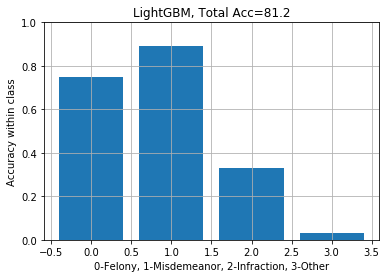

Wall time: 25.7 s


In [17]:
%%time
if RUN_LGB1:
    estimators = 100
    objective = 'multiclass'
    l_rate = 0.1
    leaves = 31
    r_alpha = 0.0
    r_lambda = 0.0
    depth = -1
    subsample = 1.0
    thread = 0
    split_gain = 0.0
    colsample = 1.0

    LightGBMa(estimators, l_rate, leaves, r_alpha, r_lambda, depth, subsample, thread, split_gain, colsample)

AUC Score Weighted 0.9008624116352387
AUC Score Micro 0.9604171752926469
AUC Score Macro 0.9246935646002696
              precision    recall  f1-score   support

           0      0.792     0.741     0.766     10624
           1      0.824     0.885     0.853     19075
           2      0.672     0.364     0.473       708
           3      0.205     0.087     0.122       687

    accuracy                          0.806     31094
   macro avg      0.623     0.519     0.554     31094
weighted avg      0.796     0.806     0.799     31094



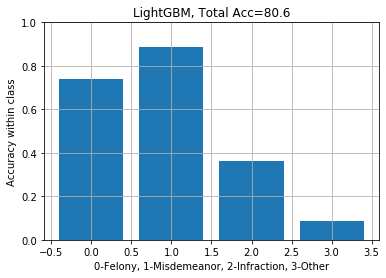

Wall time: 3min 53s


In [18]:
%%time
if RUN_LGB1:
    estimators = 1000
    objective = 'multiclass'
    l_rate = 0.05
    leaves = 31
    r_alpha = 0.0
    r_lambda = 0.0
    depth = -1
    subsample = 1.0
    thread = 0
    split_gain = 0.0
    colsample = 1.0

    LightGBMa(estimators, l_rate, leaves, r_alpha, r_lambda, depth, subsample, thread, split_gain, colsample)

AUC Score Weighted 0.8813199528217172
AUC Score Micro 0.9516626757209459
AUC Score Macro 0.9071962119917735
              precision    recall  f1-score   support

           0      0.743     0.725     0.734     10624
           1      0.816     0.849     0.832     19075
           2      0.557     0.369     0.444       708
           3      0.178     0.106     0.133       687

    accuracy                          0.779     31094
   macro avg      0.573     0.512     0.536     31094
weighted avg      0.771     0.779     0.774     31094



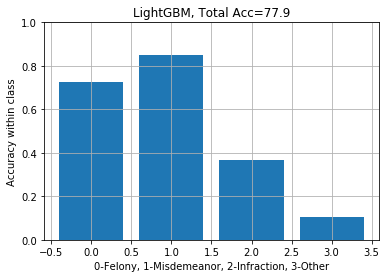

Wall time: 32min 18s


In [19]:
%%time
if RUN_LGB1:
    estimators = 10000
    objective = 'multiclass'
    l_rate = 0.05
    leaves = 31
    r_alpha = 0.0
    r_lambda = 0.0
    depth = -1
    subsample = 1.0
    thread = 0
    split_gain = 0.0
    colsample = 1.0

    LightGBMa(estimators, l_rate, leaves, r_alpha, r_lambda, depth, subsample, thread, split_gain, colsample)

AUC Score Weighted 0.9065546110360967
AUC Score Micro 0.9630540459327998
AUC Score Macro 0.9305149073043674
              precision    recall  f1-score   support

           0      0.797     0.747     0.771     10624
           1      0.822     0.895     0.857     19075
           2      0.760     0.345     0.474       708
           3      0.220     0.013     0.025       687

    accuracy                          0.813     31094
   macro avg      0.650     0.500     0.532     31094
weighted avg      0.799     0.813     0.801     31094



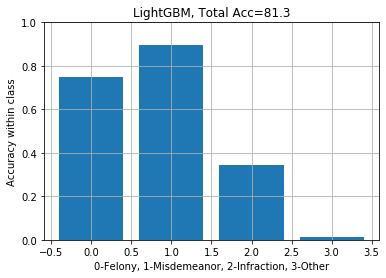

Wall time: 2min


In [20]:
%%time
if RUN_LGB1:
    estimators = 1000
    objective = 'multiclass'
    l_rate = 0.05
    leaves = 31
    r_alpha = 0.5
    r_lambda = 0.5
    depth = 2
    subsample = 1.0
    thread = 0
    split_gain = 0.02
    colsample = 0.8

    LightGBMa(estimators, l_rate, leaves, r_alpha, r_lambda, depth, subsample, thread, split_gain, colsample)

AUC Score Weighted 0.9065546110360967
AUC Score Micro 0.9630540459327998
AUC Score Macro 0.9305149073043674
              precision    recall  f1-score   support

           0      0.797     0.747     0.771     10624
           1      0.822     0.895     0.857     19075
           2      0.760     0.345     0.474       708
           3      0.220     0.013     0.025       687

    accuracy                          0.813     31094
   macro avg      0.650     0.500     0.532     31094
weighted avg      0.799     0.813     0.801     31094



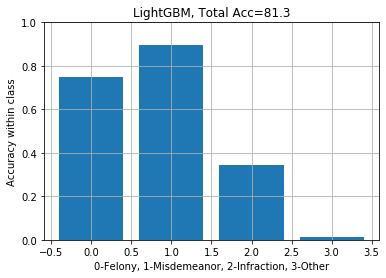

Wall time: 13min 56s


In [21]:
%%time
if RUN_LGB1:
    estimators = 10000
    objective = 'multiclass'
    l_rate = 0.05
    leaves = 31
    r_alpha = 0.5
    r_lambda = 0.5
    depth = 2
    subsample = 1.0
    thread = 0
    split_gain = 0.02
    colsample = 0.8

    LightGBMa(estimators, l_rate, leaves, r_alpha, r_lambda, depth, subsample, thread, split_gain, colsample)

AUC Score Weighted 0.9057207431729554
AUC Score Micro 0.9626673550392806
AUC Score Macro 0.9292791767003392
              precision    recall  f1-score   support

           0      0.796     0.747     0.771     10624
           1      0.822     0.893     0.856     19075
           2      0.725     0.350     0.472       708
           3      0.266     0.025     0.045       687

    accuracy                          0.811     31094
   macro avg      0.652     0.504     0.536     31094
weighted avg      0.799     0.811     0.800     31094



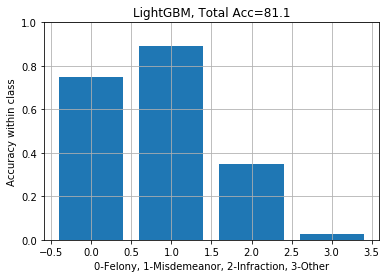

Wall time: 15min 17s


In [22]:
%%time
if RUN_LGB1:
    estimators = 10000
    objective = 'multiclass'
    l_rate = 0.05
    leaves = 31
    r_alpha = 0.05
    r_lambda = 0.05
    depth = 7
    subsample = 1.0
    thread = 0
    split_gain = 0.02
    colsample = 0.8

    LightGBMa(estimators, l_rate, leaves, r_alpha, r_lambda, depth, subsample, thread, split_gain, colsample)

AUC Score Weighted 0.90578659203201
AUC Score Micro 0.9626655881089468
AUC Score Macro 0.9292951641784356
              precision    recall  f1-score   support

           0      0.796     0.747     0.771     10624
           1      0.822     0.893     0.856     19075
           2      0.729     0.350     0.473       708
           3      0.254     0.023     0.043       687

    accuracy                          0.812     31094
   macro avg      0.650     0.503     0.536     31094
weighted avg      0.799     0.812     0.800     31094



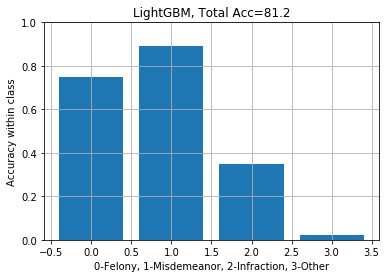

Wall time: 19min 20s


In [23]:
%%time
if RUN_LGB1:
    estimators = 10000
    objective = 'multiclass'
    l_rate = 0.05
    leaves = 34
    r_alpha = 0.05
    r_lambda = 0.05
    depth = 7
    subsample = 1.0
    thread = 0
    split_gain = 0.02
    colsample = 0.8

    LightGBMa(estimators, l_rate, leaves, r_alpha, r_lambda, depth, subsample, thread, split_gain, colsample)

#### LightGBM Performance - Arrest Type Code

`Table 2` shows the results from the LightGBM models for `Arrest Type Code`.

The winning model used 1000 estimators, an L1 regularization of .5, an L2 regularization of .5, a tree depth of 2, a split gain of .2 and 80% of the features for testing (all other parameters were the defaults). The Micro AUC is 81.3%. 

Note that there are other models with a Micro AUC of 81.3%, but they use more estimates and therefore take more time to run. We choose the model with the highest Micro AUC that had the fastest run time.

In general, execution time increases with the number of estimators used and the depth of the tree. Model performance does not necessarily improve with the number of estimators or tree depth.

#### Table 2: LightGBM Performance for Arrest Type Code
Performance metrics for each Arrest Type are listed as *Precision, Recall*.

| Estim. | L Rate | Leaves | L1 | L2 | Depth | Split Gain | Col Smpl | Time | ACC | Micro AUC | Felony | Misdemeanor | Infraction | Other | 
| :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- |
| 100 | 0.1 | 31 | 0 | 0 | -1 | 0 | 1 | 00:25 | 81.2% | 96.259% | 79.6%, 75.0% | 82.3%, 89.3% | 75.2%, 33.1% | 26.0%, 2.9% | 
| 1000 | 0.05 | 31 | 0 | 0 | -1 | 0 | 1 | 03:53 | 80.6% | 96.042% | 79.2%, 74.1% | 82.4%, 88.5% | 67.2%, 36.4% | 20.5%, 8.7% | 
| 10000 | 0.05 | 31 | 0 | 0 | -1 | 0 | 1 | 32:18 | 77.9% | 95.166% | 74.3%, 72.5% | 81.6%, 84.9% | 55.7%, 36.9% | 17.8%, 10.6% | 
| **1000** | **0.05** | **31** | **0.5** | **0.5** | **2** | **0.02** | **0.8** | **02:00** | **81.3%** | **96.305%** | **79.7%, 74.7%** | **82.2%, 89.5%** | **76.0%, 34.5%** | **22.0%, 1.3%** | 
| 10000 | 0.05 | 31 | 0.5 | 0.5 | 2 | 0.02 | 0.8 | 13:56 | 81.3% | 96.305% | 79.7%, 74.7% | 82.2%, 89.5% | 76.0%, 34.5% | 22.0%, 1.3% | 
| 10000 | 0.05 | 31 | 0.05 | 0.05 | 7 | 0.02 | 0.8 | 15:17 | 81.1% | 96.267% | 79.6%, 74.7% | 82.2%, 89.3% | 72.5%, 35.0% | 26.6%, 2.5% | 
| 10000 | 0.05 | 34 | 0.05 | 0.05 | 7 | 0.02 | 0.8 | 19:20 | 81.2% | 96.267% | 79.6%, 74.7% | 82.2%, 89.3% | 72.9%, 35.0% | 25.4%, 2.3% | 

<a href='#Section_0'> Back to top </a>
<a id = 'Section_7_a_2'></a>

### XGBoost - Arrest Type Code

XGBoost stands for eXtreme Gradient Boosting and is Tianqi Chen and Carlos Guestrin's implementation of gradient boosting machines. This algorithm is designed with speed and performance in mind. This model also has the added benefit of being able to handle missing data values automatically.

XGBoost uses the gradient boosting decision tree algorithm. Enhancements to the alogithm include ([see article by Vishal Morde and Venkat Anurag Setty](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)):
* Regularization where more complex models are penalized to prevent overfitting
* Sparsity awareness to handle missing data values automatically
* Weighted Quantile Sketch to find the optimal split points in weighted data

We explore several different parameters to tune our XGBoost model. These include:
* booster: options are `gbtree` (default), `gblinear` and `dart`. `gbtree` and `dart` use tree based models and `gblinear` uses linear models.
* tree_method: options are `auto` (default), `exact`, `approx`, `hist` and `gpu_hist`. `auto` will choose the fastest method but it is still recommended to try `hist` and `gpu_hist` with large datasets. We were unable to get `gpu_hist` working but will show runs using `auto` and `hist`.
* max_depth: range [0,$\infty$]. 6 (default) indicates the maximum depth of the tree is 6. Larger values increase the liklihood that the model will overfit the data.
* max_delta_step: range [0,$\infty$]. 0 (default) indicates there is no constraint on the maximum delta step for each leaf output. For unbalanced datasets it is recommended to try a value in the range [1,10] to help control the update.


In [24]:
#KGBoost 
import pickle
import xgboost as xgb

import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def XGBoosta(boost, tree, depth, delta_step, etaparm):
    for train, test in cv.split(Xa,ya):
        xgb_model = xgb.XGBClassifier(booster=boost, tree_method=tree, max_depth=depth, max_delta_step=delta_step,eta=etaparm).fit(Xa[train], ya[train])
        yhata[test] = xgb_model.predict(Xa[test])
        yhata_score[test] = xgb_model.predict_proba(Xa[test])
    
    lb=LabelBinarizer()
    lb.fit(ya)
    ya_lb = lb.transform(ya)
    yhata_lb = lb.transform(yhata)
    print ('AUC Score Weighted', roc_auc_score(ya_lb, yhata_score, average='weighted', multi_class='ovr'))
    print ('AUC Score Micro', roc_auc_score(ya_lb, yhata_score, average='micro', multi_class='ovr'))
    print ('AUC Score Macro', roc_auc_score(ya_lb, yhata_score, average='macro', multi_class='ovr'))

    print (mt.classification_report(ya,yhata,digits=3))
                
    plot_class_acc(ya,yhata,title="XGBoost")

#### Defaults

AUC Score Weighted 0.9042297140996574
AUC Score Micro 0.9621261082499067
AUC Score Macro 0.9287219306738212
              precision    recall  f1-score   support

           0      0.808     0.739     0.772     10624
           1      0.816     0.900     0.856     19075
           2      0.738     0.342     0.467       708
           3      0.250     0.001     0.003       687

    accuracy                          0.812     31094
   macro avg      0.653     0.496     0.524     31094
weighted avg      0.799     0.812     0.799     31094



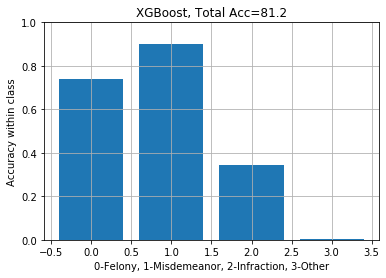

Wall time: 4min 52s


In [25]:
%%time
if RUN_XGB1:
    boost='gbtree'
    tree='auto'
    depth=6
    delta_step=0
    etaparm=0.3

    XGBoosta(boost,tree,depth,delta_step,etaparm)

#### Modifying Booster Parameter

AUC Score Weighted 0.8889299661717962
AUC Score Micro 0.9363723768657348
AUC Score Macro 0.9008768800639958
              precision    recall  f1-score   support

           0      0.928     0.475     0.628     10624
           1      0.728     0.980     0.835     19075
           2      0.000     0.000     0.000       708
           3      0.000     0.000     0.000       687

    accuracy                          0.763     31094
   macro avg      0.414     0.364     0.366     31094
weighted avg      0.764     0.763     0.727     31094



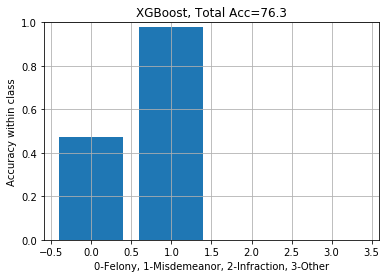

Wall time: 1min 9s


In [26]:
%%time
if RUN_XGB1:
    boost='gblinear'
    tree='auto'
    depth=6
    delta_step=0
    etaparm=0.3

    XGBoosta(boost,tree,depth,delta_step,etaparm)

AUC Score Weighted 0.9042297146049749
AUC Score Micro 0.9621261094565909
AUC Score Macro 0.9287219426710502
              precision    recall  f1-score   support

           0      0.808     0.739     0.772     10624
           1      0.816     0.900     0.856     19075
           2      0.738     0.342     0.467       708
           3      0.250     0.001     0.003       687

    accuracy                          0.812     31094
   macro avg      0.653     0.496     0.524     31094
weighted avg      0.799     0.812     0.799     31094



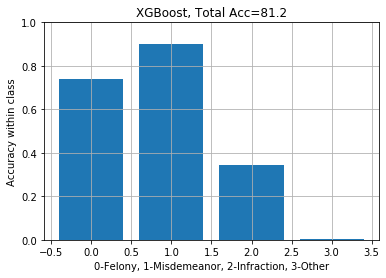

Wall time: 7min 44s


In [27]:
%%time
if RUN_XGB1:
    boost='dart'
    tree='auto'
    depth=6
    delta_step=0
    etaparm=0.3

    XGBoosta(boost,tree,depth,delta_step,etaparm)

#### Modifying Booster & Tree Method Parameters

AUC Score Weighted 0.9042286888807872
AUC Score Micro 0.9621254476765371
AUC Score Macro 0.9287210185791896
              precision    recall  f1-score   support

           0      0.808     0.739     0.772     10624
           1      0.816     0.900     0.856     19075
           2      0.738     0.342     0.467       708
           3      0.250     0.001     0.003       687

    accuracy                          0.812     31094
   macro avg      0.653     0.496     0.524     31094
weighted avg      0.799     0.812     0.799     31094



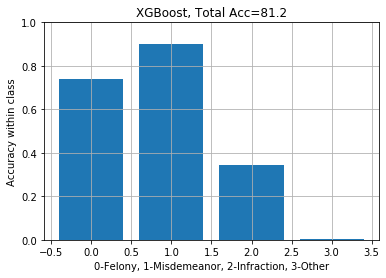

Wall time: 1min 11s


In [28]:
%%time
if RUN_XGB1:
    boost='gbtree'
    tree='hist'
    depth=6
    delta_step=0
    etaparm=0.3

    XGBoosta(boost,tree,depth,delta_step,etaparm)

AUC Score Weighted 0.8889299661717962
AUC Score Micro 0.9363723768657348
AUC Score Macro 0.9008768800639958
              precision    recall  f1-score   support

           0      0.928     0.475     0.628     10624
           1      0.728     0.980     0.835     19075
           2      0.000     0.000     0.000       708
           3      0.000     0.000     0.000       687

    accuracy                          0.763     31094
   macro avg      0.414     0.364     0.366     31094
weighted avg      0.764     0.763     0.727     31094



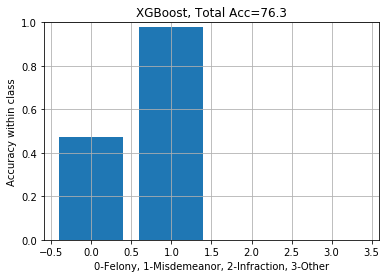

Wall time: 1min 7s


In [29]:
%%time
if RUN_XGB1:
    boost='gblinear'
    tree='hist'
    depth=6
    delta_step=0
    etaparm=0.3

    XGBoosta(boost,tree,depth,delta_step,etaparm)

AUC Score Weighted 0.904228689386105
AUC Score Micro 0.9621254488832212
AUC Score Macro 0.9287210305764185
              precision    recall  f1-score   support

           0      0.808     0.739     0.772     10624
           1      0.816     0.900     0.856     19075
           2      0.738     0.342     0.467       708
           3      0.250     0.001     0.003       687

    accuracy                          0.812     31094
   macro avg      0.653     0.496     0.524     31094
weighted avg      0.799     0.812     0.799     31094



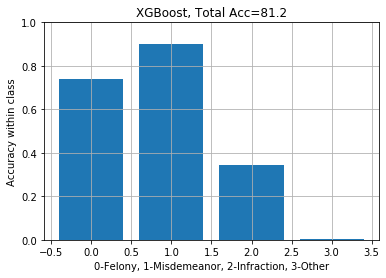

Wall time: 3min 41s


In [30]:
%%time
if RUN_XGB1:
    boost='dart'
    tree='hist'
    depth=6
    delta_step=0
    etaparm=0.3

    XGBoosta(boost,tree,depth,delta_step,etaparm)

#### Modifying Booster, Tree Method and Max Depth

AUC Score Weighted 0.9033746298472441
AUC Score Micro 0.9618564462377048
AUC Score Macro 0.9284521672455895
              precision    recall  f1-score   support

           0      0.807     0.740     0.772     10624
           1      0.815     0.899     0.855     19075
           2      0.765     0.331     0.462       708
           3      1.000     0.003     0.006       687

    accuracy                          0.812     31094
   macro avg      0.847     0.493     0.524     31094
weighted avg      0.815     0.812     0.799     31094



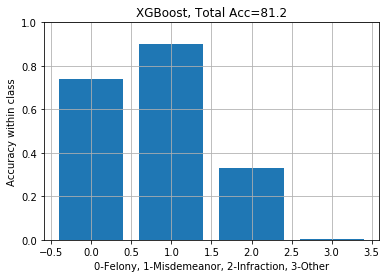

Wall time: 1min 7s


In [31]:
%%time
if RUN_XGB1:
    boost='gbtree'
    tree='hist'
    depth=5
    delta_step=0
    etaparm=0.3

    XGBoosta(boost,tree,depth,delta_step,etaparm)

AUC Score Weighted 0.9044939794377204
AUC Score Micro 0.9621795719417543
AUC Score Macro 0.9288233986320397
              precision    recall  f1-score   support

           0      0.808     0.739     0.772     10624
           1      0.815     0.899     0.855     19075
           2      0.720     0.342     0.464       708
           3      0.167     0.003     0.006       687

    accuracy                          0.812     31094
   macro avg      0.627     0.496     0.524     31094
weighted avg      0.796     0.812     0.799     31094



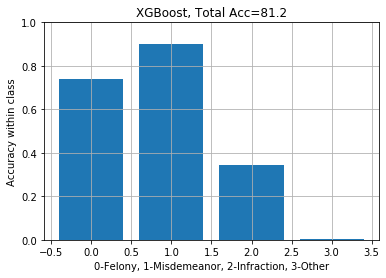

Wall time: 1min 17s


In [32]:
%%time
if RUN_XGB1:
    boost='gbtree'
    tree='hist'
    depth=7
    delta_step=0
    etaparm=0.3

    XGBoosta(boost,tree,depth,delta_step,etaparm)

#### Modifying Booster, Tree Method and Max Delta Step

AUC Score Weighted 0.9041952058883191
AUC Score Micro 0.9621181937810791
AUC Score Macro 0.928821207996755
              precision    recall  f1-score   support

           0      0.808     0.739     0.772     10624
           1      0.816     0.900     0.855     19075
           2      0.740     0.338     0.464       708
           3      0.286     0.003     0.006       687

    accuracy                          0.812     31094
   macro avg      0.662     0.495     0.524     31094
weighted avg      0.799     0.812     0.799     31094



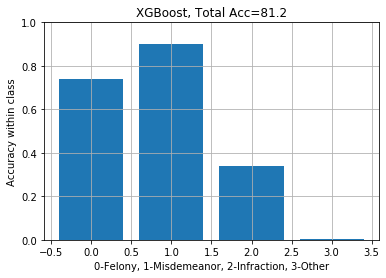

Wall time: 1min 12s


In [33]:
%%time
if RUN_XGB1:
    boost='gbtree'
    tree='hist'
    depth=6
    delta_step=1
    etaparm=0.3

    XGBoosta(boost,tree,depth,delta_step,etaparm)

AUC Score Weighted 0.9042286888807872
AUC Score Micro 0.9621254476765371
AUC Score Macro 0.9287210185791896
              precision    recall  f1-score   support

           0      0.808     0.739     0.772     10624
           1      0.816     0.900     0.856     19075
           2      0.738     0.342     0.467       708
           3      0.250     0.001     0.003       687

    accuracy                          0.812     31094
   macro avg      0.653     0.496     0.524     31094
weighted avg      0.799     0.812     0.799     31094



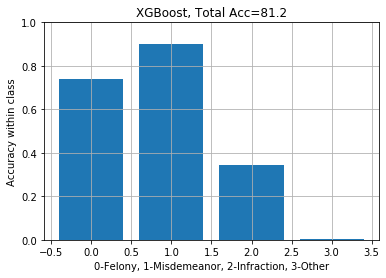

Wall time: 1min 17s


In [34]:
%%time
if RUN_XGB1:
    boost='gbtree'
    tree='hist'
    depth=6
    delta_step=5
    etaparm=0.3

    XGBoosta(boost,tree,depth,delta_step,etaparm)

AUC Score Weighted 0.9042286888807872
AUC Score Micro 0.9621254476765371
AUC Score Macro 0.9287210185791896
              precision    recall  f1-score   support

           0      0.808     0.739     0.772     10624
           1      0.816     0.900     0.856     19075
           2      0.738     0.342     0.467       708
           3      0.250     0.001     0.003       687

    accuracy                          0.812     31094
   macro avg      0.653     0.496     0.524     31094
weighted avg      0.799     0.812     0.799     31094



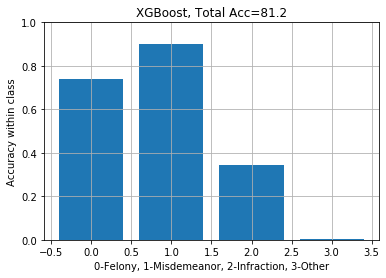

Wall time: 1min 8s


In [35]:
%%time
if RUN_XGB1:
    boost='gbtree'
    tree='hist'
    depth=6
    delta_step=10
    etaparm=0.3

    XGBoosta(boost,tree,depth,delta_step,etaparm)

#### XGBoost Performance - Arrest Type Code

`Table 3` shows the results from the XGBoost models for `Arrest Type Code`. 

The XGBoost models are extremely fast. The winning model used `gbtree` for the booster, `hist` for the tree method and `7` for the max tree depth (defaults for all other parameters) and completed in 1:17. The model achieved a micro-average AUC of 96.218%. 

We did run 100% of the data through this model and execution time was around 48:00. We choose not to include that here so that all models in the project are run with the sample sample, ensuring we can making comparisons across models.

In general, the `dart` tree method models performed much slower than `gbtree` and `gblinear`. The `gblinear` booster has much lower AUC scores. The `hist` tree method shows a great improvement in performance for the tree based `gbtree` and `dart` boosters.

#### Table 3: XGBoost Performance for Arrest Type Code
Performance metrics for each Arrest Type are listed as *Precision, Recall*.

| Booster | Tree Method | Max Depth | Max Delta Step | Time (MM:SS) | Accuracy | Micro AUC | Felony | Misdemeanor | Infraction | Other | 
| :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- |
| gbtree | auto | 6 | 0 | 4:52 | 81.2% | 96.213% | 80.8%, 73.9% | 81.6%, 90.0% | 73.8%, 34.2% | 25.0%, 1.0% |
| gblinear | auto | 6 | 0 | 1:09 | 76.3% | 93.637% | 92.8%, 47.5% | 72.8%, 98.0% | 00.0%, 00.0% | 00.0%, 00.0% |
| dart | auto | 6 | 0 | 7:44 | 81.2% | 96.213% | 80.8%, 73.9% | 81.6%, 90.0% | 73.8%, 34.2% | 25.0%, 1.0% |
| gbtree | hist | 6 | 0 | 1:11 | 81.2% | 96.213% | 80.8%, 73.9% | 81.6%, 90.0% | 73.8%, 34.2% | 25.0%, 1.0% |
| gblinear | hist | 6 | 0 | 1:07 | 76.3% | 93.637% | 92.8%, 47.5% | 72.8%, 98.0% | 00.0%, 00.0% | 00.0%, 00.0% |
| dart | hist | 6 | 0 | 3:41 | 81.2% | 96.213% | 80.8%, 73.9% | 81.6%, 90.0% | 73.8%, 34.2% | 25.0%, 1.0% |
| gbtree | hist | 5 | 0 | 1:07 | 81.2% | 96.186% | 80.7%, 74.0% | 81.5%, 89.9% | 76.5%, 33.1% | 100%, 3.0% |
| **gbtree** | **hist** | **7** | **0** | **1:17** | **81.2%** | **96.218%** | **80.8%, 73.9%** | **81.5%, 89.9%** | **72.0%, 34.2%** | **16.7%, 3.0%** |
| gbtree | hist | 6 | 1 | 1:12 | 81.2% | 96.212% | 80.8%, 73.9% | 81.6%, 90.0% | 74.0%, 33.8% | 28.6%, 3.0% |
| gbtree | hist | 6 | 5 | 1:17 | 81.2% | 96.213% | 80.8%, 73.9% | 81.6%, 90.0% | 73.8%, 34.2% | 25.0%, 1.0% |
| gbtree | hist | 6 | 10 | 1:08 | 81.2% | 96.213% | 80.8%, 73.9% | 81.6%, 90.0% | 73.8%, 34.2% | 25.0%, 1.0% |

<a href='#Section_0'> Back to top </a>
<a id = 'Section_7_a_3'></a>

### Random Forest - Arrest Type Code

The random forest model is an ensemble method of learning for classification and is more powerful than logistic regression. The random forest model groups a set of decision trees and then it predicts based on the majority of votes (when used for classification) or aggregation (when used for regression) from each of the decision trees made.

<h4 align="center">Figure 2: Random Forest</h4>
<img src="https://www.kdnuggets.com/wp-content/uploads/rand-forest-2.jpg" style="width:700px;height:500px"/>

Image source: [KDNuggets](https://www.kdnuggets.com/2017/10/random-forests-explained.html)

This ensemble method is based on randomization where each tree in the forest is built randomly with the same distribution. Each tree is trained in isolation. The basic procedure for the algorithm involves the following steps illustrated above.

- Select $\varphi_M$ bootstrap samples from the training data, $\chi$.
- For each of the bootstrap samples $\varphi_M$, grow an unpruned classification or regression tree to the largest extent possible (i.e., split the node into two daughter nodes until the minimum node size is reached).
- Predict new data by aggregating the predictions of the $\varphi_M$ trees. These predictions can be assembled into a probability distribution, whose mode (i.e., majority votes for classification) or average (i.e., aggregation for regression) yields the random forest’s proposed rating $p_{\psi}(Y=c|X=\chi)$.

The 2 sections of code below run the random forest using 100-500 estimators (i.e. number of trees in the forest), at intervals of 50 . The first code block incorporates PCA using the first 50 principle components (our dataset has 92 features). The second block of code runs just the random forest, with no feature reduction techniques.

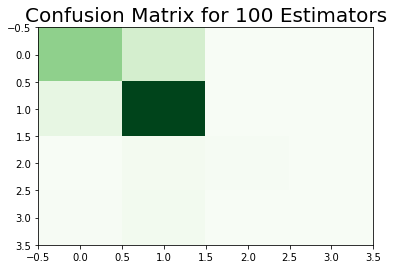

AUC Score Weighted 0.8730447898147892
AUC Score Micro 0.9485650915283635
AUC Score Macro 0.8931479049805304
              precision    recall  f1-score   support

           0      0.791     0.687     0.736     10624
           1      0.795     0.901     0.845     19075
           2      0.773     0.222     0.345       708
           3      0.312     0.015     0.028       687

    accuracy                          0.793     31094
   macro avg      0.668     0.456     0.488     31094
weighted avg      0.783     0.793     0.778     31094

Runtime: 00:01:32


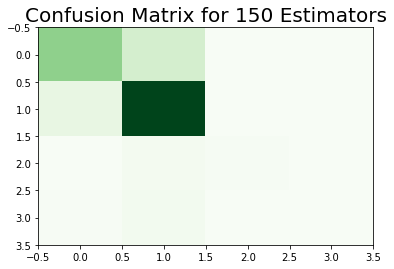

AUC Score Weighted 0.8753801597455063
AUC Score Micro 0.9492903236880809
AUC Score Macro 0.8988364469514211
              precision    recall  f1-score   support

           0      0.794     0.685     0.736     10624
           1      0.795     0.903     0.846     19075
           2      0.765     0.239     0.364       708
           3      0.371     0.019     0.036       687

    accuracy                          0.794     31094
   macro avg      0.681     0.461     0.495     31094
weighted avg      0.785     0.794     0.779     31094

Runtime: 00:02:14


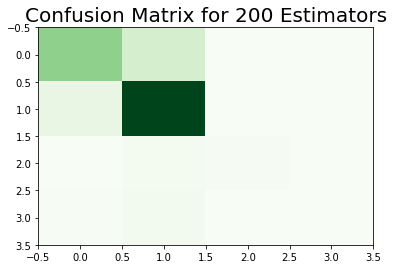

AUC Score Weighted 0.8755515685235908
AUC Score Micro 0.9494398037533329
AUC Score Macro 0.8982145780635244
              precision    recall  f1-score   support

           0      0.797     0.687     0.738     10624
           1      0.796     0.905     0.847     19075
           2      0.790     0.229     0.355       708
           3      0.361     0.019     0.036       687

    accuracy                          0.795     31094
   macro avg      0.686     0.460     0.494     31094
weighted avg      0.786     0.795     0.780     31094

Runtime: 00:02:53


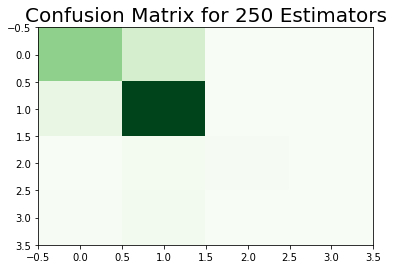

AUC Score Weighted 0.8754073822231282
AUC Score Micro 0.9493117895644597
AUC Score Macro 0.9005003157764397
              precision    recall  f1-score   support

           0      0.794     0.688     0.737     10624
           1      0.796     0.903     0.846     19075
           2      0.786     0.229     0.354       708
           3      0.306     0.016     0.030       687

    accuracy                          0.795     31094
   macro avg      0.670     0.459     0.492     31094
weighted avg      0.784     0.795     0.780     31094

Runtime: 00:03:26


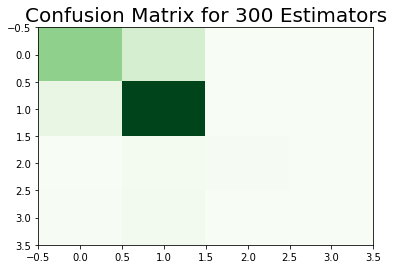

AUC Score Weighted 0.8765456313626515
AUC Score Micro 0.9496280556139947
AUC Score Macro 0.9013870807257472
              precision    recall  f1-score   support

           0      0.794     0.689     0.738     10624
           1      0.796     0.902     0.846     19075
           2      0.784     0.226     0.351       708
           3      0.294     0.015     0.028       687

    accuracy                          0.794     31094
   macro avg      0.667     0.458     0.490     31094
weighted avg      0.784     0.794     0.779     31094

Runtime: 00:04:12


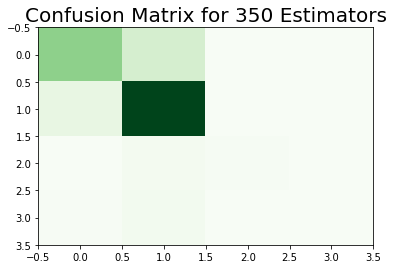

AUC Score Weighted 0.8775978585589329
AUC Score Micro 0.9500195732440352
AUC Score Macro 0.9035646136246959
              precision    recall  f1-score   support

           0      0.797     0.694     0.742     10624
           1      0.798     0.903     0.847     19075
           2      0.785     0.232     0.358       708
           3      0.367     0.016     0.031       687

    accuracy                          0.797     31094
   macro avg      0.687     0.461     0.494     31094
weighted avg      0.788     0.797     0.782     31094

Runtime: 00:04:43


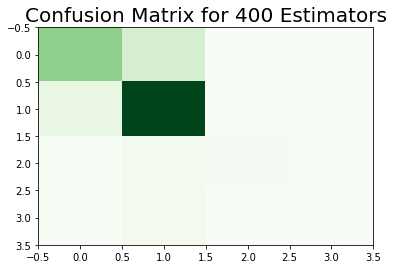

AUC Score Weighted 0.8776486288581589
AUC Score Micro 0.9501254290922224
AUC Score Macro 0.9036329806651278
              precision    recall  f1-score   support

           0      0.796     0.689     0.739     10624
           1      0.796     0.904     0.847     19075
           2      0.775     0.223     0.346       708
           3      0.306     0.016     0.030       687

    accuracy                          0.796     31094
   macro avg      0.668     0.458     0.491     31094
weighted avg      0.785     0.796     0.781     31094

Runtime: 00:05:07


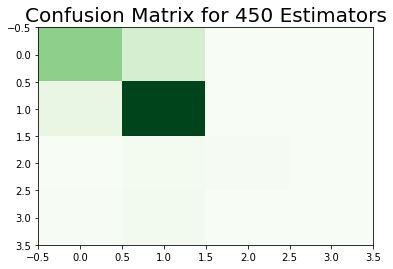

AUC Score Weighted 0.8779579590321117
AUC Score Micro 0.9502467268772261
AUC Score Macro 0.9054081724819231
              precision    recall  f1-score   support

           0      0.796     0.694     0.742     10624
           1      0.798     0.903     0.847     19075
           2      0.788     0.236     0.363       708
           3      0.375     0.017     0.033       687

    accuracy                          0.797     31094
   macro avg      0.689     0.463     0.496     31094
weighted avg      0.788     0.797     0.782     31094

Runtime: 00:05:43


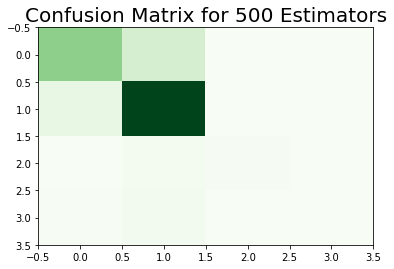

AUC Score Weighted 0.877428142337971
AUC Score Micro 0.950042821910025
AUC Score Macro 0.904984632887519
              precision    recall  f1-score   support

           0      0.799     0.692     0.742     10624
           1      0.798     0.906     0.848     19075
           2      0.791     0.230     0.357       708
           3      0.333     0.016     0.031       687

    accuracy                          0.798     31094
   macro avg      0.680     0.461     0.494     31094
weighted avg      0.788     0.798     0.783     31094

Runtime: 00:06:37
Best accuracy is  0.797710169164469  with  500  estimators in a random forest with PCA
              precision    recall  f1-score   support

           0      0.799     0.692     0.742     10624
           1      0.798     0.906     0.848     19075
           2      0.791     0.230     0.357       708
           3      0.333     0.016     0.031       687

    accuracy                          0.798     31094
   macro avg      0.680     0

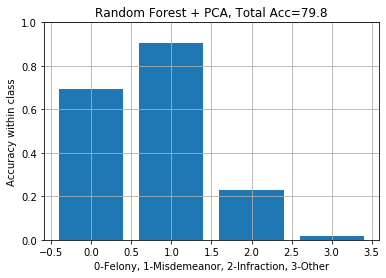

Wall time: 36min 30s


In [36]:
%%time
if RUN_RF1:
    from sklearn.ensemble import RandomForestClassifier

    maxAccPCARF = 0
    optimalEstimatorsPCARF = 0
    optimalYPCARF = []
    optimalYhatPCARF = []
    clReport = ''

    for i in range(100, 501, 50):
        rfTime = time.time()
        clf_pipe = Pipeline(
            [('PCA',PCA(n_components=50, svd_solver='randomized')),
             ('CLF',RandomForestClassifier(n_estimators=i, n_jobs=-1))]
        )

        # now iterate through and get predictions, saved to the correct row in yhat
        for train, test in cv.split(Xa,ya):
            clf_pipe.fit(Xa[train],ya[train])
            yhata[test] = clf_pipe.predict(Xa[test])
            yhata_score[test] = clf_pipe.predict_proba(Xa[test])

        plt.title('Confusion Matrix for {0} Estimators'.format(i), fontsize = 20)
        plt.imshow(mt.confusion_matrix(ya, yhata),cmap=plt.get_cmap('Greens'),aspect='auto')
        plt.grid(False)
        plt.show()

        total_accuracy = mt.accuracy_score(ya, yhata)
        if total_accuracy > maxAccPCARF:
            maxAccPCARF = total_accuracy
            optimalEstimatorsPCARF = i
            optimalYPCARF = ya
            optimalYhatPCARF = yhata
            clReport = mt.classification_report(ya,yhata,digits=3)

        lb=LabelBinarizer()
        lb.fit(ya)
        ya_lb = lb.transform(ya)
        yhata_lb = lb.transform(yhata)
        print ('AUC Score Weighted', roc_auc_score(ya_lb, yhata_score, average='weighted', multi_class='ovr'))
        print ('AUC Score Micro', roc_auc_score(ya_lb, yhata_score, average='micro', multi_class='ovr'))
        print ('AUC Score Macro', roc_auc_score(ya_lb, yhata_score, average='macro', multi_class='ovr'))

        print (mt.classification_report(ya,yhata,digits=3))

        endTime = time.time() - rfTime
        seconds = int(abs(endTime % 60))
        allMinutes = int(abs(endTime / 60))
        minutes = int(abs(allMinutes % 60))
        allHours = int(abs(allMinutes / 60))
        hours = int(abs(allMinutes / 60))
        print ("Runtime: %02d:%02d:%02d" % (hours, minutes, seconds))

    print ('Best accuracy is ', maxAccPCARF, ' with ', optimalEstimatorsPCARF, ' estimators in a random forest with PCA')
    print(clReport)
    plot_class_acc(optimalYPCARF,optimalYhatPCARF,title="Random Forest + PCA")

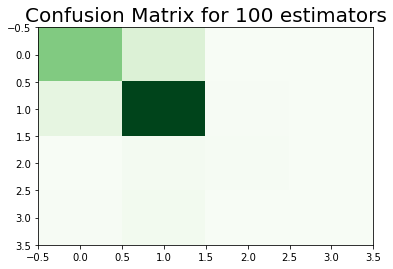

AUC Score Weighted 0.8960595755833257
AUC Score Micro 0.9582012436550013
AUC Score Macro 0.914982183197907
              precision    recall  f1-score   support

           0      0.787     0.736     0.760     10624
           1      0.819     0.888     0.852     19075
           2      0.699     0.342     0.459       708
           3      0.242     0.047     0.078       687

    accuracy                          0.805     31094
   macro avg      0.637     0.503     0.537     31094
weighted avg      0.793     0.805     0.795     31094

Runtime: 00:00:33


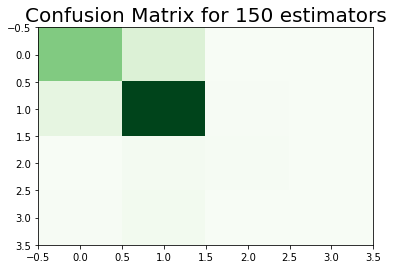

AUC Score Weighted 0.896772606447265
AUC Score Micro 0.9586901027700053
AUC Score Macro 0.9187266448057199
              precision    recall  f1-score   support

           0      0.787     0.738     0.762     10624
           1      0.820     0.888     0.853     19075
           2      0.713     0.336     0.457       708
           3      0.244     0.047     0.078       687

    accuracy                          0.806     31094
   macro avg      0.641     0.502     0.537     31094
weighted avg      0.794     0.806     0.796     31094

Runtime: 00:00:48


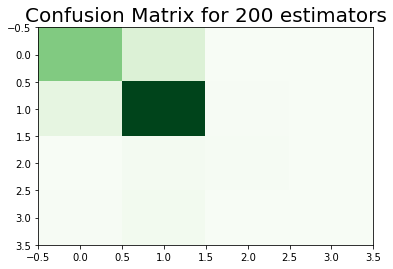

AUC Score Weighted 0.8972153836445967
AUC Score Micro 0.9589480423630307
AUC Score Macro 0.9189842261993181
              precision    recall  f1-score   support

           0      0.787     0.735     0.760     10624
           1      0.819     0.888     0.852     19075
           2      0.703     0.342     0.460       708
           3      0.250     0.045     0.076       687

    accuracy                          0.805     31094
   macro avg      0.640     0.503     0.537     31094
weighted avg      0.793     0.805     0.795     31094

Runtime: 00:01:02


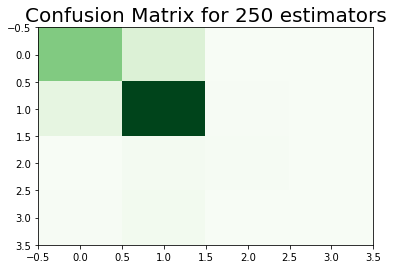

AUC Score Weighted 0.8974398249751668
AUC Score Micro 0.9591572984571998
AUC Score Macro 0.9203575532629963
              precision    recall  f1-score   support

           0      0.786     0.736     0.760     10624
           1      0.819     0.888     0.852     19075
           2      0.707     0.335     0.454       708
           3      0.266     0.049     0.083       687

    accuracy                          0.805     31094
   macro avg      0.645     0.502     0.538     31094
weighted avg      0.793     0.805     0.795     31094

Runtime: 00:01:19


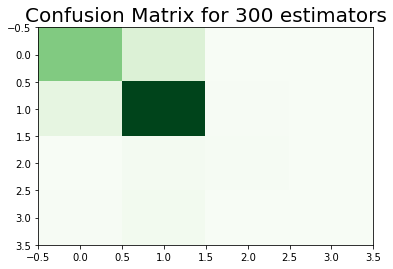

AUC Score Weighted 0.897410513911202
AUC Score Micro 0.9591445627681209
AUC Score Macro 0.9201661323485517
              precision    recall  f1-score   support

           0      0.788     0.736     0.761     10624
           1      0.819     0.889     0.853     19075
           2      0.706     0.342     0.461       708
           3      0.228     0.042     0.071       687

    accuracy                          0.806     31094
   macro avg      0.635     0.502     0.536     31094
weighted avg      0.793     0.806     0.795     31094

Runtime: 00:01:53


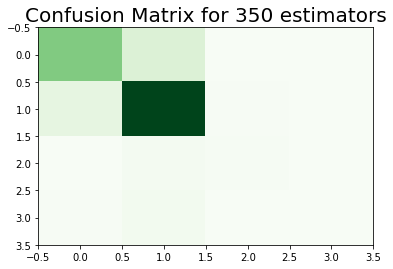

AUC Score Weighted 0.8977924168319265
AUC Score Micro 0.9592923953647682
AUC Score Macro 0.9202148527001627
              precision    recall  f1-score   support

           0      0.790     0.737     0.762     10624
           1      0.819     0.890     0.853     19075
           2      0.705     0.335     0.454       708
           3      0.268     0.049     0.084       687

    accuracy                          0.806     31094
   macro avg      0.646     0.503     0.538     31094
weighted avg      0.794     0.806     0.796     31094

Runtime: 00:02:05


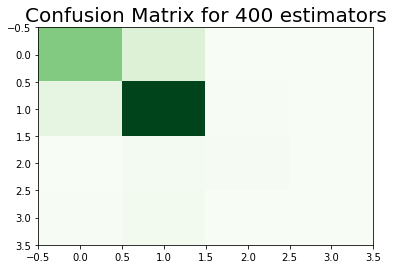

AUC Score Weighted 0.8978703389082994
AUC Score Micro 0.9593140779271399
AUC Score Macro 0.920297230295769
              precision    recall  f1-score   support

           0      0.787     0.735     0.760     10624
           1      0.819     0.889     0.852     19075
           2      0.708     0.339     0.458       708
           3      0.252     0.047     0.079       687

    accuracy                          0.805     31094
   macro avg      0.641     0.502     0.537     31094
weighted avg      0.793     0.805     0.795     31094

Runtime: 00:02:31


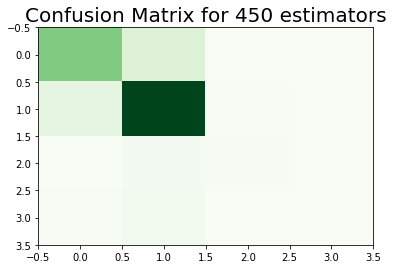

AUC Score Weighted 0.8978282447643525
AUC Score Micro 0.9593163059831948
AUC Score Macro 0.9198342402245091
              precision    recall  f1-score   support

           0      0.788     0.736     0.761     10624
           1      0.819     0.889     0.853     19075
           2      0.709     0.340     0.460       708
           3      0.272     0.049     0.084       687

    accuracy                          0.806     31094
   macro avg      0.647     0.504     0.539     31094
weighted avg      0.794     0.806     0.795     31094

Runtime: 00:02:30


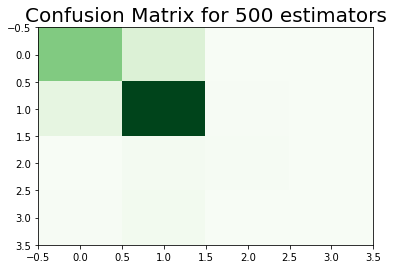

AUC Score Weighted 0.897779992886718
AUC Score Micro 0.9593402798663468
AUC Score Macro 0.9201818017812449
              precision    recall  f1-score   support

           0      0.789     0.737     0.762     10624
           1      0.819     0.889     0.853     19075
           2      0.703     0.338     0.456       708
           3      0.252     0.045     0.077       687

    accuracy                          0.806     31094
   macro avg      0.641     0.502     0.537     31094
weighted avg      0.794     0.806     0.796     31094

Runtime: 00:02:42
Best accuracy is  0.8062648742522673  with  350  Estimators in a Raw Random Forest
              precision    recall  f1-score   support

           0      0.790     0.737     0.762     10624
           1      0.819     0.890     0.853     19075
           2      0.705     0.335     0.454       708
           3      0.268     0.049     0.084       687

    accuracy                          0.806     31094
   macro avg      0.646     0.5

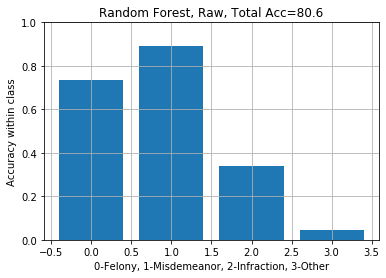

Wall time: 15min 28s


In [37]:
%%time
if RUN_RF2:
    from sklearn.ensemble import RandomForestClassifier
    maxAccRF = 0
    optimalEstimatorsRF = 0
    clReport = ''

    for i in range(100, 501, 50):
        rfTime = time.time()
        clf = RandomForestClassifier(n_estimators=i, n_jobs=-1, oob_score=True)

        # now iterate through and get predictions, saved to the correct row in yhat
        for train, test in cv.split(Xa,ya):
            clf.fit(Xa[train],ya[train])
            yhata[test] = clf.predict(Xa[test])
            yhata_score[test] = clf.predict_proba(Xa[test])
        total_accuracy = mt.accuracy_score(ya, yhata)

        plt.title('Confusion Matrix for {0} estimators'.format(i), fontsize = 20)
        plt.imshow(mt.confusion_matrix(ya, yhata),cmap=plt.get_cmap('Greens'),aspect='auto')
        plt.grid(False)
        plt.show()

        if total_accuracy > maxAccRF:
            maxAccRF = total_accuracy
            optimalEstimatorsRF = i
            optimalYRF = ya
            optimalYhatRF = yhata
            clReport = mt.classification_report(ya,yhata,digits=3)

        lb=LabelBinarizer()
        lb.fit(ya)
        ya_lb = lb.transform(ya)
        yhata_lb = lb.transform(yhata)
        print ('AUC Score Weighted', roc_auc_score(ya_lb, yhata_score, average='weighted', multi_class='ovr'))
        print ('AUC Score Micro', roc_auc_score(ya_lb, yhata_score, average='micro', multi_class='ovr'))
        print ('AUC Score Macro', roc_auc_score(ya_lb, yhata_score, average='macro', multi_class='ovr'))
        
        print (mt.classification_report(ya,yhata,digits=3))

        endTime = time.time() - rfTime
        seconds = int(abs(endTime % 60))
        allMinutes = int(abs(endTime / 60))
        minutes = int(abs(allMinutes % 60))
        allHours = int(abs(allMinutes / 60))
        hours = int(abs(allMinutes / 60))
        print ("Runtime: %02d:%02d:%02d" % (hours, minutes, seconds))

    print ('Best accuracy is ', maxAccRF, ' with ', optimalEstimatorsRF, ' Estimators in a Raw Random Forest')
    print(clReport)
    plot_class_acc(optimalYRF,optimalYhatRF,title="Random Forest, Raw")

#### Random Forest Performance - Arrest Type Code

`Table 4` shows the results for the random forest models for `Arrest Type Code`.

The winning model did not use PCA and used the maximum number of estimators we set, 500. The micro-average AUC for this model was 95.934%.

We tried a range of estimators with random forest, both with PCA reduction first and using only random forest.  The results were remakably similar, though the version without PCA was slightly better.  

#### Table 4: Random Forest Performance for Arrest Type Code
Performance metrics for each Arrest Type are listed as *Precision, Recall*.

| PCA | Estimators | Time | Accuracy | AUC | Felony | Misdemeanor | Infraction | Other | 
| :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- |
| 50 | 100 | 01:32 | 79.3% | 94.857% | 79.1%, 68.7% | 79.5%, 90.1% | 77.3%, 22.2% | 31.2%, 1.5% |
| 50 | 150 | 02:14 | 79.4% | 94.929% | 79.4%, 68.5% | 79.5%, 90.3% | 76.5%, 23.9% | 37.1%, 1.9% |
| 50 | 200 | 02:53 | 79.5% | 94.944% | 79.7%, 68.7% | 79.6%, 90.5% | 79.0%, 22.9% | 36.1%, 1.9% |
| 50 | 250 | 03:26 | 79.5% | 94.931% | 79.4%, 68.8% | 79.6%, 90.3% | 78.6%, 22.9% | 30.6%, 1.6% |
| 50 | 300 | 04:12 | 79.4% | 94.963% | 79.4%, 68.9% | 79.6%, 90.2% | 78.4%, 22.6% | 29.4%, 1.5% |
| 50 | 350 | 04:43 | 79.7% | 95.002% | 79.7%, 69.4% | 79.8%, 90.3% | 78.5%, 23.2% | 36.7%, 1.6% |
| 50 | 400 | 05:07 | 79.6% | 95.013% | 79.6%, 68.9% | 79.6%, 90.4% | 77.5%, 22.3% | 30.6%, 1.6% |
| 50 | 450 | 05:43 | 79.7% | 95.025% | 79.6%, 69.4% | 79.8%, 90.3% | 78.8%, 23.6% | 37.5%, 1.7% |
| 50 | 500 | 06:37 | 79.8% | 95.004% | 79.9%, 69.2% | 79.8%, 90.6% | 79.1%, 23.0% | 33.3%, 1.6% |
| NA | 100 | 00:33 | 80.5% | 95.820% | 78.7%, 73.6% | 81.9%, 88.8% | 69.9%, 34.2% | 24.2%, 4.7% |
| NA | 150 | 00:48 | 80.6% | 95.869% | 78.7%, 73.8% | 82.0%, 88.8% | 71.3%, 33.6% | 24.4%, 4.7% |
| NA | 200 | 01:02 | 80.5% | 95.895% | 78.7%, 73.5% | 81.9%, 88.8% | 70.3%, 34.2% | 25.0%, 4.5% |
| NA | 250 | 01:19 | 80.5% | 95.916% | 78.6%, 73.6% | 81.9%, 88.8%% | 70.7%, 33.5% | 26.6%, 4.9% |
| NA | 300 | 01:53 | 80.6% | 95.914% | 78.8%, 73.6% | 81.9%, 88.9% | 70.6%, 34.2% | 22.8%, 4.2% |
| NA | 350 | 02:05 | 80.6% | 95.929% | 79.0%, 73.7% | 81.9%, 89.0% | 70.5%, 33.5% | 26.8%, 4.9% |
| NA | 400 | 02:31 | 80.5% | 95.931% | 78.7%, 73.5% | 81.9%, 88.9% | 70.8%, 33.9% | 25.2%, 4.7% |
| NA | 450 | 02:30 | 80.6% | 95.932% | 78.8%, 73.6% | 81.9%, 88.9% | 70.9%, 34.0% | 27.2%, 4.9% |
| **NA** | **500** | **02:42** | **80.6%** | **95.934%** | **78.9%, 73.7%** | **81.9%, 88.9%** | **70.3%, 33.8%** | **25.2%, 4.5%** |

<a href='#Section_0'> Back to top </a>
<a id = 'Section_7_a_4'></a>

### SVM - Arrest Type Code

In this section, we will explore support vector machines. First, a variety of SVM kernels are used, and we compare the results to see which ones are the most and least accurate. We also look at a stochastic gradient descent (SGD) model. 

One thing that we noticed right away is just how long it takes to train SVM models. We found that the training time grew exponentially as the size of the dataset grew, and we simply did not have enough time, after days of waiting, to use the full dataset in this section.  The SVM models created the critical path in regards to time for running this project. We sampled the data down to 5% for the entire project due to the processing time required here. Again, we wanted to make sure we were using the sample samples for all models to enable comparisons.

In [38]:
#changing the sample size because we can't get the full dataset through SVM
df_arrest2 = df_arrest
df_descent2 = df_descent

#subsample of dataframe
df_arrest2 = pd.DataFrame.sample(df_arrest2, frac = SVM_SUB_SAMPLE_SIZE, random_state = 34128)
df_descent2 = pd.DataFrame.sample(df_descent2, frac = SVM_SUB_SAMPLE_SIZE, random_state = 34128)

print("The datasets have {:,} rows and {:,} columns".format(*df_arrest2.shape))

The datasets have 31,094 rows and 93 columns


In [39]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt


# create variables we are more familiar with
if 'Arrest Type Code' in df_arrest2:
    yaS = df_arrest2['Arrest Type Code'].values # get the labels we want
    del df_arrest2['Arrest Type Code'] # get rid of the class label
    XaS = df_arrest2.values # use everything else to predict!
    
yhataS = np.zeros(yaS.shape) # we will fill this with predictions
yhataS_score = np.zeros((yaS.shape[0],4))

scl = StandardScaler()
XaS = scl.fit_transform(XaS)

# create cross validation iterator
cv = StratifiedKFold(n_splits=10, random_state=1234)

In [40]:
def SVMa(krnl):
    for train, test in cv.split(XaS,yaS):
        svm_clf = SVC(C=0.5, kernel=krnl, degree=3, gamma='auto', probability=True).fit(XaS[train], yaS[train])
        yhataS[test] = svm_clf.predict(XaS[test])
        yhataS_score[test] = svm_clf.predict_proba(XaS[test])
        
    lb=LabelBinarizer()
    lb.fit(yaS)
    yaS_lb = lb.transform(yaS)
    yhataS_lb = lb.transform(yhataS)
    print ('AUC Score Weighted', roc_auc_score(yaS_lb, yhataS_score, average='weighted', multi_class='ovr'))
    print ('AUC Score Micro', roc_auc_score(yaS_lb, yhataS_score, average='micro', multi_class='ovr'))
    print ('AUC Score Macro', roc_auc_score(yaS_lb, yhataS_score, average='macro', multi_class='ovr'))


    print (mt.classification_report(yaS,yhataS,digits=3))

    plot_class_acc(yaS,yhataS,title="SVM")

#### SVM Sigmoid Kernel
Now, we can start our SVM analysis.  Here we train a model using a Sigmoid kernel.  The sigmoid is a special function that is guaranteed to have a y-value constrained between 0 and 1 and crosses the y-axis at x=0.  

In [41]:
%%time
if RUN_SVM1:
    krnl='sigmoid'
    SVMa(krnl)

Wall time: 0 ns


#### SVM Linear Kernel

The linear kernel is the simplest model to use conceptually, as it really is as simple as drawing a line between clusters of data points (or a plane in three dimensions, a cube in four, and so on).

In [42]:
%%time
if RUN_SVM1:
    krnl='linear'
    SVMa(krnl)

Wall time: 0 ns


#### SVM Polynomial Kernel
Next, we use the polynomial kernel, which allows us to learn a non-linear model.  We can specify the degree (i.e. the highest number of exponents of the polynomial).  In this case, we chose to go with 3.  While higher order polynomials would result in better accuracy, they would likely overfit the model, thus making it a poor predictor.

In [43]:
%%time
if RUN_SVM2:
    krnl='poly'
    SVMa(krnl)

Wall time: 0 ns


#### SVM Radial Basis Function Kernel
For our final SVM model, we use RBF, which, much like sigmoid, ranges between 0 and 1.  It measures the distance between points and the support vectors, and another useful property is that RBF decreases with distance.

In [44]:
%%time
if RUN_SVM2:
    krnl='rbf'
    SVMa(krnl)

Wall time: 0 ns


#### Stochastic Gradient Descent
To see what the differences might be, we also tried a model with SGD.  Much like SVM, this also involved the use of some scaling before getting the test set prediction.  Execution time here improved dramatically, but there was a slight decrease in AUC.

In [45]:
%%time
if RUN_SVM2:
    # Linear SVM classifier with Stochastic Descent
    from sklearn.linear_model import SGDClassifier

    regularize_const = 0.1
    iterations = 5

    for train, test in cv.split(XaS,yaS):
        svm_clf = svm_sgd = SGDClassifier(alpha=regularize_const,
            fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
            loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2').fit(XaS[train], yaS[train])
        yhataS[test] = svm_clf.predict(XaS[test])
        yhata_score[test] = svm_clf.predict_proba(Xa[test])

    lb=LabelBinarizer()
    lb.fit(yaS)
    yaS_lb = lb.transform(yaS)
    yhataS_lb = lb.transform(yhataS)
    print ('AUC Score Weighted', roc_auc_score(yaS_lb, yhataS_score, average='weighted', multi_class='ovr'))
    print ('AUC Score Micro', roc_auc_score(yaS_lb, yhataS_score, average='micro', multi_class='ovr'))
    print ('AUC Score Macro', roc_auc_score(yaS_lb, yhataS_score, average='macro', multi_class='ovr'))

    print (mt.classification_report(yaS,yhataS,digits=3))

    plot_class_acc(yaS,yhataS,title="SGD")

Wall time: 0 ns


#### SVM Performance - Arrest Type Code

`Table 5` shows the results from the SVM and SGD models for `Arrest Type Code`.

The winning SVM model is the linear kernel with an AUC of 79.350%. Unfortunately, this is also the longest running SVM model. The AUC score is comparable to the LightGBM and XGBoost models.

#### Table 5: SVM Performance for Arrest Type Code
Performance metrics for each Arrest Type are listed as *Precision, Recall*.

| Kernel | Time (HH:MM:SS) | Accuracy | AUC | Felony | Misdemeanor | Infraction | Other | 
| :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- | 
| sigmoid | 0:43:32 | 77.1% | 75.285% | 74.5%, 71.1% | 78.9%, 85.6% | 22.7%, 06.9% | 00.0%, 00.0% |
| **linear** | **1:47:42** | **81.2%** | **79.350%** | **80.5%, 74.5%** | **81.7%, 89.4%** | **67.6%, 37.3%** | **00.0%, 00.0%** | 
| polynomial | 1:31:27 | 81.2% | 79.085% | 80.9%, 73.6% | 81.4%, 90.2% | 84.6%, 30.5% | 00.0%, 00.0% |
| rbf | 1:31:45 | 81.4% | 79.345% | 80.6%, 74.5% | 81.7%, 89.9% | 85.1%, 30.5% | 00.0%, 00.0% |
| SGD | 0:00:03 | 80.6% | 78.272% | 80.5%, 74.0% | 80.7%, 90.0% | 00.0%, 00.0% | 00.0%, 00.0% |

<a href='#Section_0'> Back to top </a>  
<a id = 'Section_7_b'></a>

### b. Descent Code

In [46]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt


# create variables we are more familiar with
if 'Descent Code' in df_descent1:
    yd = df_descent1['Descent Code'].values # get the labels we want
    del df_descent1['Descent Code'] # get rid of the class label
    Xd = df_descent1.values # use everything else to predict!
    
yhatd = np.zeros(yd.shape) # we will fill this with predictions
yhatd_score = np.zeros((yd.shape[0],4))

scl = StandardScaler()
Xd = scl.fit_transform(Xd)

# create cross validation iterator
cv = StratifiedKFold(n_splits=10, random_state=1234)

<a href='#Section_0'> Back to top </a>  
<a id = 'Section_7_b_1'></a>

### LightGBM Descent Code

In [0]:
import lightgbm as lgb
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, roc_auc_score


def LightGBMd(estimators, l_rate, leaves, r_alpha, r_lambda, depth, subsample, thread, split_gain, colsample):
    for train, test in cv.split(Xd,yd):
        lgbm_model = lgb.LGBMClassifier(n_estimators = estimators,
                                        objective = 'multiclass',
                                        learning_rate = l_rate,
                                        num_leaves = leaves,
                                        lambda_l1 = r_alpha,
                                        lambda_l2 = r_lambda, 
                                        maxdepth = depth,
                                        bagging_fraction = subsample,
                                        nthread = thread,
                                        min_gain_to_split = split_gain,
                                        feature_fraction = colsample,
                                        random_state = 17).fit(Xd[train], yd[train])
        yhatd[test] = lgbm_model.predict(Xd[test])
        yhatd_score[test] = lgbm_model.predict_proba(Xd[test])

    lb=LabelBinarizer()
    lb.fit(yd)
    yd_lb = lb.transform(yd)
    yhatd_lb = lb.transform(yhatd)
    print ('AUC Score Weighted', roc_auc_score(yd_lb, yhatd_score, average='weighted', multi_class='ovr'))
    print ('AUC Score Micro', roc_auc_score(yd_lb, yhatd_score, average='micro', multi_class='ovr'))
    print ('AUC Score Macro', roc_auc_score(yd_lb, yhatd_score, average='macro', multi_class='ovr'))

    print (mt.classification_report(yd, yhatd, digits = 3))
                
    plot_class_acc(yd, yhatd, title = "LightGBM")

AUC Score Weighted 0.7661518063036895
AUC Score Micro 0.8293799275558424
AUC Score Macro 0.7564972921193885
              precision    recall  f1-score   support

           0      0.600     0.595     0.597      9110
           1      0.615     0.758     0.679     14424
           2      0.448     0.329     0.379      5775
           3      0.314     0.009     0.017      1785

    accuracy                          0.587     31094
   macro avg      0.494     0.423     0.418     31094
weighted avg      0.562     0.587     0.561     31094



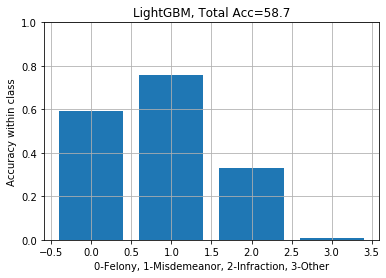

CPU times: user 1min 34s, sys: 627 ms, total: 1min 35s
Wall time: 48.7 s


In [16]:
%%time
if RUN_LGB2:
    estimators = 100
    objective = 'multiclass'
    l_rate = 0.1
    leaves = 31
    r_alpha = 0.0
    r_lambda = 0.0
    depth = -1
    subsample = 1.0
    thread = 0
    split_gain = 0.0
    colsample = 1.0

    LightGBMd(estimators, l_rate, leaves, r_alpha, r_lambda, depth, subsample, thread, split_gain, colsample)

AUC Score Weighted 0.7566056002196966
AUC Score Micro 0.8220833430609313
AUC Score Macro 0.743842332641285
              precision    recall  f1-score   support

           0      0.588     0.585     0.587      9110
           1      0.618     0.744     0.675     14424
           2      0.437     0.338     0.381      5775
           3      0.235     0.028     0.050      1785

    accuracy                          0.581     31094
   macro avg      0.470     0.424     0.423     31094
weighted avg      0.554     0.581     0.559     31094



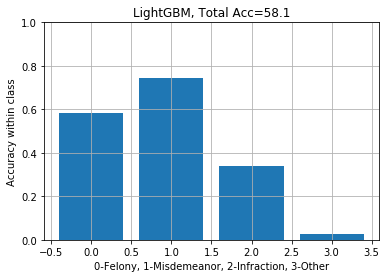

CPU times: user 11min 29s, sys: 5.1 s, total: 11min 34s
Wall time: 5min 50s


In [17]:
%%time
if RUN_LGB2:
    estimators = 1000
    objective = 'multiclass'
    l_rate = 0.05
    leaves = 31
    r_alpha = 0.0
    r_lambda = 0.0
    depth = -1
    subsample = 1.0
    thread = 0
    split_gain = 0.0
    colsample = 1.0

    LightGBMd(estimators, l_rate, leaves, r_alpha, r_lambda, depth, subsample, thread, split_gain, colsample)

AUC Score Weighted 0.7153103373263374
AUC Score Micro 0.7903044004417722
AUC Score Macro 0.7021405475584039
              precision    recall  f1-score   support

           0      0.533     0.542     0.537      9110
           1      0.599     0.670     0.633     14424
           2      0.366     0.315     0.339      5775
           3      0.144     0.060     0.085      1785

    accuracy                          0.531     31094
   macro avg      0.411     0.397     0.398     31094
weighted avg      0.511     0.531     0.519     31094



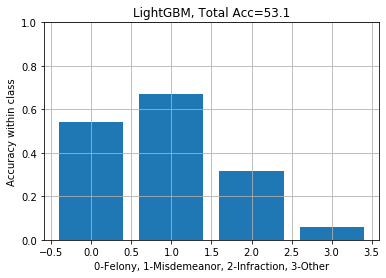

CPU times: user 1h 46min 37s, sys: 49.3 s, total: 1h 47min 26s
Wall time: 54min 6s


In [18]:
%%time
if RUN_LGB2:
    estimators = 10000
    objective = 'multiclass'
    l_rate = 0.05
    leaves = 31
    r_alpha = 0.0
    r_lambda = 0.0
    depth = -1
    subsample = 1.0
    thread = 0
    split_gain = 0.0
    colsample = 1.0

    LightGBMd(estimators, l_rate, leaves, r_alpha, r_lambda, depth, subsample, thread, split_gain, colsample)

AUC Score Weighted 0.7658222200181845
AUC Score Micro 0.8290580583547398
AUC Score Macro 0.7561457700717144
              precision    recall  f1-score   support

           0      0.596     0.590     0.593      9110
           1      0.618     0.751     0.678     14424
           2      0.447     0.347     0.391      5775
           3      0.274     0.010     0.018      1785

    accuracy                          0.586     31094
   macro avg      0.484     0.424     0.420     31094
weighted avg      0.560     0.586     0.562     31094



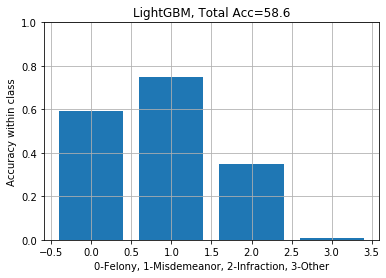

CPU times: user 8min 12s, sys: 2.33 s, total: 8min 14s
Wall time: 4min 9s


In [19]:
%%time
if RUN_LGB2:
    estimators = 1000
    objective = 'multiclass'
    l_rate = 0.05
    leaves = 31
    r_alpha = 0.5
    r_lambda = 0.5
    depth = 2
    subsample = 1.0
    thread = 0
    split_gain = 0.02
    colsample = 0.8

    LightGBMd(estimators, l_rate, leaves, r_alpha, r_lambda, depth, subsample, thread, split_gain, colsample)

AUC Score Weighted 0.7658222200181845
AUC Score Micro 0.8290580583547398
AUC Score Macro 0.7561457700717144
              precision    recall  f1-score   support

           0      0.596     0.590     0.593      9110
           1      0.618     0.751     0.678     14424
           2      0.447     0.347     0.391      5775
           3      0.274     0.010     0.018      1785

    accuracy                          0.586     31094
   macro avg      0.484     0.424     0.420     31094
weighted avg      0.560     0.586     0.562     31094



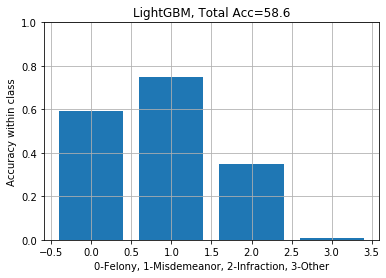

CPU times: user 1h 5min 46s, sys: 5.38 s, total: 1h 5min 52s
Wall time: 33min 4s


In [20]:
%%time
if RUN_LGB2:
    estimators = 10000
    objective = 'multiclass'
    l_rate = 0.05
    leaves = 31
    r_alpha = 0.5
    r_lambda = 0.5
    depth = 2
    subsample = 1.0
    thread = 0
    split_gain = 0.02
    colsample = 0.8

    LightGBMd(estimators, l_rate, leaves, r_alpha, r_lambda, depth, subsample, thread, split_gain, colsample)

AUC Score Weighted 0.7635966930080934
AUC Score Micro 0.8273694069995764
AUC Score Macro 0.7533542220629443
              precision    recall  f1-score   support

           0      0.595     0.587     0.591      9110
           1      0.619     0.751     0.679     14424
           2      0.446     0.348     0.391      5775
           3      0.232     0.013     0.024      1785

    accuracy                          0.586     31094
   macro avg      0.473     0.425     0.421     31094
weighted avg      0.558     0.586     0.562     31094



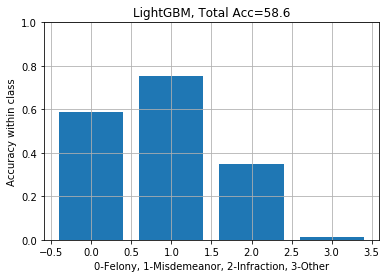

CPU times: user 1h 6min 18s, sys: 6.21 s, total: 1h 6min 24s
Wall time: 33min 20s


In [21]:
%%time
if RUN_LGB2:
    estimators = 10000
    objective = 'multiclass'
    l_rate = 0.05
    leaves = 31
    r_alpha = 0.05
    r_lambda = 0.05
    depth = 7
    subsample = 1.0
    thread = 0
    split_gain = 0.02
    colsample = 0.8

    LightGBMd(estimators, l_rate, leaves, r_alpha, r_lambda, depth, subsample, thread, split_gain, colsample)

AUC Score Weighted 0.7639499723364164
AUC Score Micro 0.82760034979332
AUC Score Macro 0.75363301266263
              precision    recall  f1-score   support

           0      0.593     0.587     0.590      9110
           1      0.618     0.750     0.678     14424
           2      0.447     0.347     0.391      5775
           3      0.240     0.014     0.026      1785

    accuracy                          0.585     31094
   macro avg      0.475     0.424     0.421     31094
weighted avg      0.557     0.585     0.561     31094



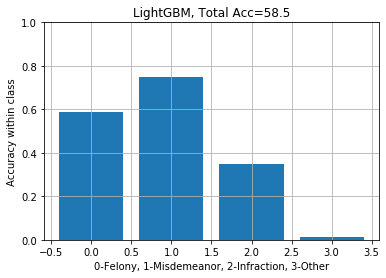

CPU times: user 1h 6min 14s, sys: 6.19 s, total: 1h 6min 20s
Wall time: 33min 19s


In [22]:
%%time
if RUN_LGB2:
    estimators = 10000
    objective = 'multiclass'
    l_rate = 0.05
    leaves = 34
    r_alpha = 0.05
    r_lambda = 0.05
    depth = 7
    subsample = 1.0
    thread = 0
    split_gain = 0.02
    colsample = 0.8

    LightGBMd(estimators, l_rate, leaves, r_alpha, r_lambda, depth, subsample, thread, split_gain, colsample)

#### LightGBM Performance for Descent Code

`Table 6` summarizes the results for the LightGBM models for `Descent Code`.

We changed various parameters over seven iterations of the model. The best performing version was the first iteration with 100 estimators. This model achieved a micro-average AUC score of 82.938% and ran in under 1 minute. Other versions of the model with many more estimators and a smaller learning rate came close in terms of micro-average AUC but took much longer to execute.

#### Table 6: LightGBM Performance for Descent Code
Performance metrics for each Descent Code are listed as *Precision, Recall*.

| Estim. | L Rate | Leaves | R Alpha | R Lambda | Depth | Split Gain | Col Smpl | Time | ACC | Micro AUC | Black | Hispanic | White | Other | 
| :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- |
| **100** | **0.1** | **31** | **0** | **0** | **-1** | **0** | **1** | **0:00:49** | **58.7%** | **82.938%** | **60.0%, 59.5%** | **61.5%, 75.8%** | **44.8%, 32.9%** | **31.4%, 0.9%** | 
| 1000 | 0.05 | 31 | 0 | 0 | -1 | 0 | 1 | 0:05:50 | 58.1% | 82.208% | 58.8%, 58.5% | 61.8%, 74.4% | 43.7%, 33.8% | 23.5%, 2.8% | 
| 10000 | 0.05 | 31 | 0 | 0 | -1 | 0 | 1 | 1:46:37 | 53.1% | 79.030% | 53.3%, 54.2% | 59.9%, 67.0% | 36.6%, 31.5% | 14.4%, 6.0% | 
| 1000 | 0.05 | 31 | 0.5 | 0.5 | 2 | 0.02 | 0.8 | 0:04:09 | 58.6% | 82.906% | 59.6%, 59.0% | 61.8%, 75.1% | 44.7%, 34.7% | 27.4%, 1.0% | 
| 10000 | 0.05 | 31 | 0.5 | 0.5 | 2 | 0.02 | 0.8 | 0:33:04 | 58.6% | 82.906% | 59.6%, 59.0% | 61.8%, 75.1% | 44.7%, 34.7% | 27.4%, 1.0% | 
| 10000 | 0.05 | 31 | 0.05 | 0.05 | 7 | 0.02 | 0.8 | 0:33:20 | 58.6% | 82.737% | 59.5%, 58.7% | 61.9%, 75.1% | 44.6%, 34.8% | 23.2%, 1.3% | 
| 10000 | 0.05 | 34 | 0.05 | 0.05 | 7 | 0.02 | 0.8 | 0:33:19 | 58.5% | 82.760% | 59.3%, 58.7% | 61.8%, 75.0% | 44.7%, 34.7% | 24.0%, 1.4% | 

<a href='#Section_0'> Back to top </a>  
<a id = 'Section_7_b_2'></a>

### XGBoost - Descent Code

In [55]:
#KGBoost 
import pickle
import xgboost as xgb

import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def XGBoostd(boost, tree, depth, delta_step, etaparm):
    for train, test in cv.split(Xd,yd):
        xgb_model = xgb.XGBClassifier(booster=boost, tree_method=tree, max_depth=depth, max_delta_step=delta_step,eta=etaparm).fit(Xd[train], yd[train])
        yhatd[test] = xgb_model.predict(Xd[test])
        yhatd_score[test] = xgb_model.predict_proba(Xd[test])

    lb=LabelBinarizer()
    lb.fit(yd)
    yd_lb = lb.transform(yd)
    yhatd_lb = lb.transform(yhatd)
    print ('AUC Score Weighted', roc_auc_score(yd_lb, yhatd_score, average='weighted', multi_class='ovr'))
    print ('AUC Score Micro', roc_auc_score(yd_lb, yhatd_score, average='micro', multi_class='ovr'))
    print ('AUC Score Macro', roc_auc_score(yd_lb, yhatd_score, average='macro', multi_class='ovr'))
    
    print (mt.classification_report(yd,yhatd,digits=3))
                
    plot_class_acc(yd,yhatd,title="XGBoost")

#### Defaults

#### Modifying Booster and Tree Method Parameters

AUC Score Weighted 0.7626956310976817
AUC Score Micro 0.8270347945245231
AUC Score Macro 0.7514917838006605
              precision    recall  f1-score   support

           0      0.607     0.571     0.589      9110
           1      0.600     0.781     0.679     14424
           2      0.459     0.297     0.361      5775
           3      0.143     0.001     0.001      1785

    accuracy                          0.585     31094
   macro avg      0.452     0.413     0.407     31094
weighted avg      0.550     0.585     0.554     31094



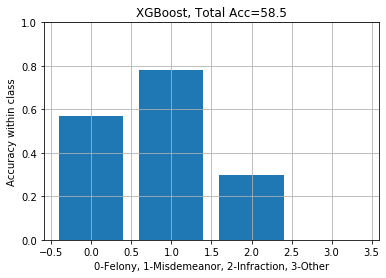

Wall time: 1min 20s


In [56]:
%%time
if RUN_XGB2:
    boost='gbtree'
    tree='hist'
    depth=6
    delta_step=0
    etaparm=0.3

    XGBoostd(boost,tree,depth,delta_step,etaparm)

AUC Score Weighted 0.7472191845035474
AUC Score Micro 0.7825630668254762
AUC Score Macro 0.7351286964656192
              precision    recall  f1-score   support

           0      0.695     0.172     0.276      9110
           1      0.485     0.970     0.647     14424
           2      0.000     0.000     0.000      5775
           3      0.000     0.000     0.000      1785

    accuracy                          0.500     31094
   macro avg      0.295     0.286     0.231     31094
weighted avg      0.429     0.500     0.381     31094



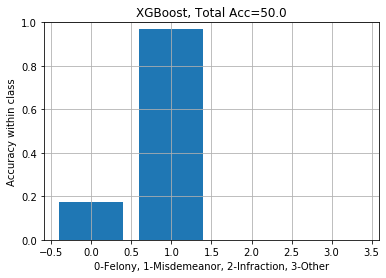

Wall time: 1min 5s


In [57]:
%%time
if RUN_XGB2:
    boost='gblinear'
    tree='hist'
    depth=6
    delta_step=0
    etaparm=0.3

    XGBoostd(boost,tree,depth,delta_step,etaparm)

#### Modifying Booster, Tree Method and Max Depth Parameters

AUC Score Weighted 0.7623818046160603
AUC Score Micro 0.8266467331825987
AUC Score Macro 0.7514974180497862
              precision    recall  f1-score   support

           0      0.606     0.565     0.585      9110
           1      0.595     0.788     0.678     14424
           2      0.466     0.283     0.352      5775
           3      0.500     0.001     0.001      1785

    accuracy                          0.584     31094
   macro avg      0.542     0.409     0.404     31094
weighted avg      0.569     0.584     0.551     31094



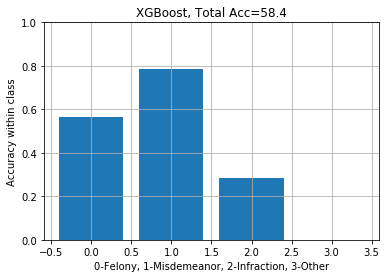

Wall time: 1min 11s


In [58]:
%%time
if RUN_XGB2:
    boost='gbtree'
    tree='hist'
    depth=5
    delta_step=0
    etaparm=0.3

    XGBoostd(boost,tree,depth,delta_step,etaparm)

AUC Score Weighted 0.7629160162852975
AUC Score Micro 0.8271842694182716
AUC Score Macro 0.7522038562896365
              precision    recall  f1-score   support

           0      0.601     0.575     0.588      9110
           1      0.605     0.774     0.679     14424
           2      0.458     0.309     0.369      5775
           3      0.222     0.002     0.004      1785

    accuracy                          0.585     31094
   macro avg      0.471     0.415     0.410     31094
weighted avg      0.554     0.585     0.556     31094



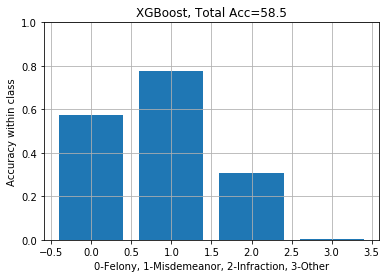

Wall time: 1min 27s


In [59]:
%%time
if RUN_XGB2:
    boost='gbtree'
    tree='hist'
    depth=7
    delta_step=0
    etaparm=0.3

    XGBoostd(boost,tree,depth,delta_step,etaparm)

#### Modifying Booster, Tree Method and Max Delta Step Parameters

AUC Score Weighted 0.7628658103646992
AUC Score Micro 0.8271272049809792
AUC Score Macro 0.7518380191074898
              precision    recall  f1-score   support

           0      0.603     0.569     0.586      9110
           1      0.600     0.781     0.679     14424
           2      0.459     0.296     0.360      5775
           3      0.222     0.001     0.002      1785

    accuracy                          0.584     31094
   macro avg      0.471     0.412     0.407     31094
weighted avg      0.553     0.584     0.553     31094



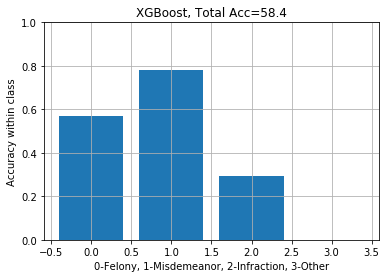

Wall time: 1min 21s


In [60]:
%%time
if RUN_XGB2:
    boost='gbtree'
    tree='hist'
    depth=6
    delta_step=1
    etaparm=0.3

    XGBoostd(boost,tree,depth,delta_step,etaparm)

AUC Score Weighted 0.7626956310976817
AUC Score Micro 0.8270347945245231
AUC Score Macro 0.7514917838006605
              precision    recall  f1-score   support

           0      0.607     0.571     0.589      9110
           1      0.600     0.781     0.679     14424
           2      0.459     0.297     0.361      5775
           3      0.143     0.001     0.001      1785

    accuracy                          0.585     31094
   macro avg      0.452     0.413     0.407     31094
weighted avg      0.550     0.585     0.554     31094



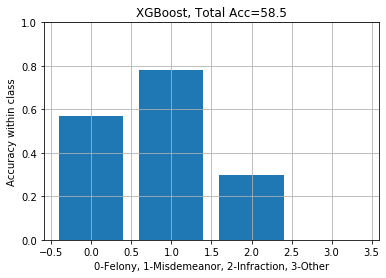

Wall time: 1min 18s


In [61]:
%%time
if RUN_XGB2:
    boost='gbtree'
    tree='hist'
    depth=6
    delta_step=5
    etaparm=0.3

    XGBoostd(boost,tree,depth,delta_step,etaparm)

AUC Score Weighted 0.7626956310976817
AUC Score Micro 0.8270347945245231
AUC Score Macro 0.7514917838006605
              precision    recall  f1-score   support

           0      0.607     0.571     0.589      9110
           1      0.600     0.781     0.679     14424
           2      0.459     0.297     0.361      5775
           3      0.143     0.001     0.001      1785

    accuracy                          0.585     31094
   macro avg      0.452     0.413     0.407     31094
weighted avg      0.550     0.585     0.554     31094



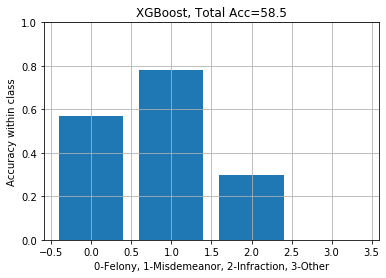

Wall time: 1min 20s


In [62]:
%%time
if RUN_XGB2:
    boost='gbtree'
    tree='hist'
    depth=6
    delta_step=10
    etaparm=0.3

    XGBoostd(boost,tree,depth,delta_step,etaparm)

#### XGBoost Performance for Descent Code

`Table 7` shows the results for the XGBoost models for `Descent Code`.

The winning model used `gbtree` for the booster, `hist` for the tree method and `7` for the max tree depth (defaults for all other parameters) and completed in 1:27. The model achieved a micro-average AUC of 82.718%. The parameters used in the winning model for `Descent Code` were the same parameters used in the winning model for `Arrest Type Code`.

#### Table 7: XGBoost Performance for Descent Code
Performance metrics for each Descent Code are listed as *Precision, Recall*.

| Booster | Tree Method | Max Depth | Max Delta Step | Time (MM:SS) | Accuracy | Micro AUC | Black | Hispanic | White | Other | 
| :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- |
| gbtree | hist | 6 | 0 | 1:20 | 58.5% | 82.703% | 60.7%, 57.1% | 60.0%, 78.1% | 45.9%, 29.7% | 14.3%, 1.0% |
| gblinear | hist | 6 | 0 | 1:05 | 50.0% | 78.256% | 69.5%, 17.2% | 48.5%, 97.0% | 00.0%, 00.0% | 00.0%, 00.0% |
| gbtree | hist | 5 | 0 | 1:11 | 58.4% | 82.665% | 60.6%, 56.5% | 59.5%, 78.8% | 46.6%, 28.3% | 50.0%, 1.0% |
| **gbtree** | **hist** | **7** | **0** | **1:27** | **58.5%** | **82.718%** | **60.1%, 57.5%** | **60.5%, 77.4%** | **45.8%, 30.9%** | **22.2%, 0.2%** |
| gbtree | hist | 6 | 1 | 1:21 | 58.4% | 82.713% | 60.2%, 56.9% | 60.0%, 78.1% | 45.9%, 29.6% | 22.2%, 0.1% |
| gbtree | hist | 6 | 5 | 1:18 | 58.5% | 82.703% | 60.7%, 57.1% | 60.0%, 78.1% | 45.9%, 29.7% | 14.3%, 0.1% |
| gbtree | hist | 6 | 10 | 1:20 | 58.5% | 82.703% | 60.7%, 57.1% | 60.0%, 78.1% | 45.9%, 29.7% | 14.3%, 0.1% |

<a href='#Section_0'> Back to top </a>  
<a id = 'Section_7_b_3'></a>

### Random Forest - Descent Code

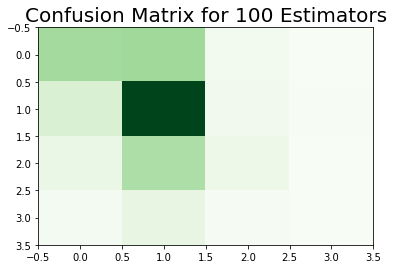

AUC Score Weighted 0.7084994371447421
AUC Score Micro 0.7938861912925019
AUC Score Macro 0.6905170354860177
              precision    recall  f1-score   support

           0      0.557     0.467     0.508      9110
           1      0.549     0.818     0.657     14424
           2      0.429     0.139     0.210      5775
           3      0.090     0.006     0.011      1785

    accuracy                          0.542     31094
   macro avg      0.406     0.357     0.346     31094
weighted avg      0.503     0.542     0.493     31094

Runtime: 00:01:22


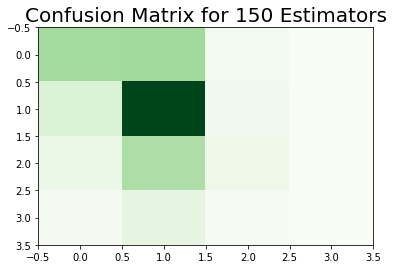

AUC Score Weighted 0.7142013928904263
AUC Score Micro 0.7965646425439531
AUC Score Macro 0.6995884447603283
              precision    recall  f1-score   support

           0      0.572     0.473     0.518      9110
           1      0.551     0.822     0.660     14424
           2      0.429     0.141     0.213      5775
           3      0.113     0.007     0.014      1785

    accuracy                          0.547     31094
   macro avg      0.416     0.361     0.351     31094
weighted avg      0.509     0.547     0.498     31094

Runtime: 00:02:02


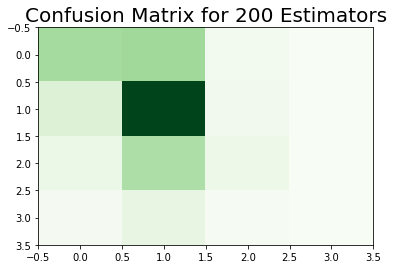

AUC Score Weighted 0.7185709755663966
AUC Score Micro 0.7983281988165098
AUC Score Macro 0.7027479492115785
              precision    recall  f1-score   support

           0      0.572     0.466     0.514      9110
           1      0.550     0.826     0.660     14424
           2      0.429     0.139     0.210      5775
           3      0.093     0.006     0.011      1785

    accuracy                          0.546     31094
   macro avg      0.411     0.359     0.349     31094
weighted avg      0.508     0.546     0.496     31094

Runtime: 00:02:40


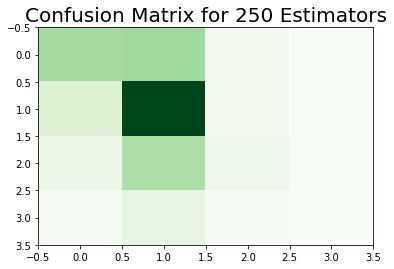

AUC Score Weighted 0.718545202378802
AUC Score Micro 0.7982376935419122
AUC Score Macro 0.7042922334422852
              precision    recall  f1-score   support

           0      0.574     0.468     0.516      9110
           1      0.549     0.828     0.660     14424
           2      0.428     0.134     0.205      5775
           3      0.110     0.006     0.012      1785

    accuracy                          0.546     31094
   macro avg      0.415     0.359     0.348     31094
weighted avg      0.509     0.546     0.496     31094

Runtime: 00:03:14


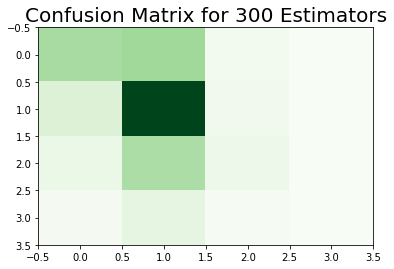

AUC Score Weighted 0.7189571348170696
AUC Score Micro 0.7987288425986284
AUC Score Macro 0.7057187782312946
              precision    recall  f1-score   support

           0      0.577     0.466     0.515      9110
           1      0.548     0.828     0.660     14424
           2      0.424     0.134     0.203      5775
           3      0.101     0.006     0.012      1785

    accuracy                          0.546     31094
   macro avg      0.412     0.358     0.347     31094
weighted avg      0.508     0.546     0.495     31094

Runtime: 00:03:53


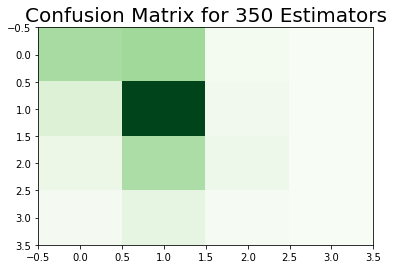

AUC Score Weighted 0.7210783607709162
AUC Score Micro 0.7995974698602955
AUC Score Macro 0.7085002636117831
              precision    recall  f1-score   support

           0      0.578     0.464     0.515      9110
           1      0.547     0.830     0.659     14424
           2      0.433     0.132     0.202      5775
           3      0.108     0.007     0.013      1785

    accuracy                          0.546     31094
   macro avg      0.416     0.358     0.347     31094
weighted avg      0.509     0.546     0.495     31094

Runtime: 00:04:28


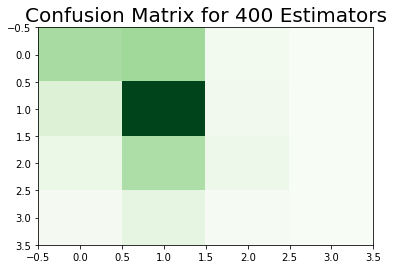

AUC Score Weighted 0.7219545508479439
AUC Score Micro 0.7997406034565555
AUC Score Macro 0.7084648862858602
              precision    recall  f1-score   support

           0      0.571     0.463     0.512      9110
           1      0.548     0.827     0.659     14424
           2      0.434     0.139     0.210      5775
           3      0.102     0.006     0.012      1785

    accuracy                          0.545     31094
   macro avg      0.414     0.359     0.348     31094
weighted avg      0.508     0.545     0.495     31094

Runtime: 00:05:11


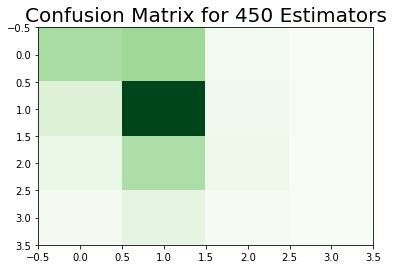

AUC Score Weighted 0.720928299874632
AUC Score Micro 0.7993283575789065
AUC Score Macro 0.7093758585899572
              precision    recall  f1-score   support

           0      0.571     0.460     0.510      9110
           1      0.548     0.829     0.660     14424
           2      0.443     0.139     0.211      5775
           3      0.104     0.006     0.012      1785

    accuracy                          0.546     31094
   macro avg      0.416     0.359     0.348     31094
weighted avg      0.509     0.546     0.495     31094

Runtime: 00:05:35


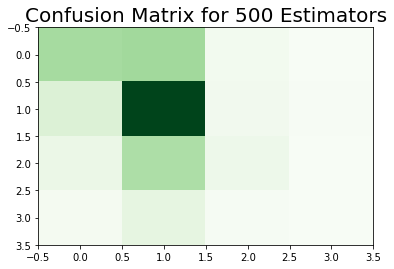

AUC Score Weighted 0.7235919502477098
AUC Score Micro 0.8006488318503965
AUC Score Macro 0.711884781460449
              precision    recall  f1-score   support

           0      0.576     0.468     0.516      9110
           1      0.548     0.827     0.659     14424
           2      0.433     0.137     0.208      5775
           3      0.097     0.006     0.012      1785

    accuracy                          0.546     31094
   macro avg      0.414     0.359     0.349     31094
weighted avg      0.509     0.546     0.496     31094

Runtime: 00:05:54
Best accuracy is  0.5468257541647906  with  150  estimators in a random forest with PCA
              precision    recall  f1-score   support

           0      0.572     0.473     0.518      9110
           1      0.551     0.822     0.660     14424
           2      0.429     0.141     0.213      5775
           3      0.113     0.007     0.014      1785

    accuracy                          0.547     31094
   macro avg      0.416   

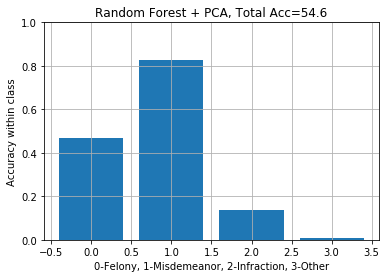

Wall time: 34min 22s


In [63]:
%%time
if RUN_RF3:
    from sklearn.ensemble import RandomForestClassifier

    maxAccPCARF = 0
    optimalEstimatorsPCARF = 0
    optimalYPCARF = []
    optimalYhatPCARF = []
    clReport = ''

    for i in range(100, 501, 50):
        rfTime = time.time()
        clf_pipe = Pipeline(
            [('PCA',PCA(n_components=50, svd_solver='randomized')),
             ('CLF',RandomForestClassifier(n_estimators=i, n_jobs=-1))]
        )

        # now iterate through and get predictions, saved to the correct row in yhat
        for train, test in cv.split(Xd,yd):
            clf_pipe.fit(Xd[train],yd[train])
            yhatd[test] = clf_pipe.predict(Xd[test])
            yhatd_score[test] = clf_pipe.predict_proba(Xd[test])

        plt.title('Confusion Matrix for {0} Estimators'.format(i), fontsize = 20)
        plt.imshow(mt.confusion_matrix(yd, yhatd),cmap=plt.get_cmap('Greens'),aspect='auto')
        plt.grid(False)
        plt.show()

        total_accuracy = mt.accuracy_score(yd, yhatd)
        if total_accuracy > maxAccPCARF:
            maxAccPCARF = total_accuracy
            optimalEstimatorsPCARF = i
            optimalYPCARF = yd
            optimalYhatPCARF = yhatd
            clReport = mt.classification_report(yd,yhatd,digits=3)

        lb=LabelBinarizer()
        lb.fit(yd)
        yd_lb = lb.transform(yd)
        yhatd_lb = lb.transform(yhatd)
        print ('AUC Score Weighted', roc_auc_score(yd_lb, yhatd_score, average='weighted', multi_class='ovr'))
        print ('AUC Score Micro', roc_auc_score(yd_lb, yhatd_score, average='micro', multi_class='ovr'))
        print ('AUC Score Macro', roc_auc_score(yd_lb, yhatd_score, average='macro', multi_class='ovr'))
        
        print (mt.classification_report(yd, yhatd, digits = 3))

        endTime = time.time() - rfTime
        seconds = int(abs(endTime % 60))
        allMinutes = int(abs(endTime / 60))
        minutes = int(abs(allMinutes % 60))
        allHours = int(abs(allMinutes / 60))
        hours = int(abs(allMinutes / 60))
        print ("Runtime: %02d:%02d:%02d" % (hours, minutes, seconds))

    print ('Best accuracy is ', maxAccPCARF, ' with ', optimalEstimatorsPCARF, ' estimators in a random forest with PCA')
    print(clReport)
    plot_class_acc(optimalYPCARF,optimalYhatPCARF,title="Random Forest + PCA")

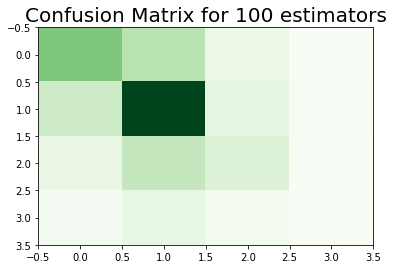

AUC Score Weighted 0.7364113669659783
AUC Score Micro 0.8080096500377857
AUC Score Macro 0.7210582876791779
              precision    recall  f1-score   support

           0      0.564     0.551     0.558      9110
           1      0.602     0.736     0.662     14424
           2      0.408     0.303     0.348      5775
           3      0.153     0.021     0.037      1785

    accuracy                          0.561     31094
   macro avg      0.432     0.403     0.401     31094
weighted avg      0.529     0.561     0.537     31094

Runtime: 00:00:33


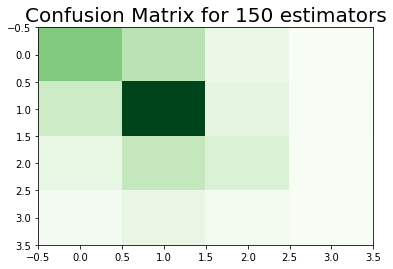

AUC Score Weighted 0.7386554647748199
AUC Score Micro 0.8097094658069067
AUC Score Macro 0.7246939648419825
              precision    recall  f1-score   support

           0      0.569     0.550     0.560      9110
           1      0.603     0.740     0.665     14424
           2      0.414     0.314     0.357      5775
           3      0.165     0.021     0.038      1785

    accuracy                          0.564     31094
   macro avg      0.438     0.406     0.405     31094
weighted avg      0.533     0.564     0.541     31094

Runtime: 00:00:51


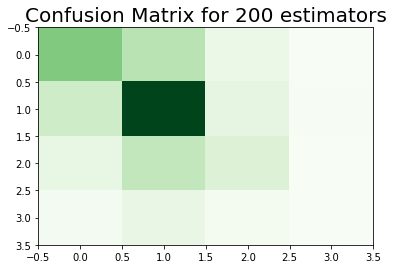

AUC Score Weighted 0.7380303996654759
AUC Score Micro 0.8092664953379305
AUC Score Macro 0.7237360961750323
              precision    recall  f1-score   support

           0      0.569     0.550     0.559      9110
           1      0.603     0.742     0.665     14424
           2      0.408     0.305     0.349      5775
           3      0.155     0.020     0.036      1785

    accuracy                          0.563     31094
   macro avg      0.434     0.404     0.402     31094
weighted avg      0.531     0.563     0.539     31094

Runtime: 00:01:09


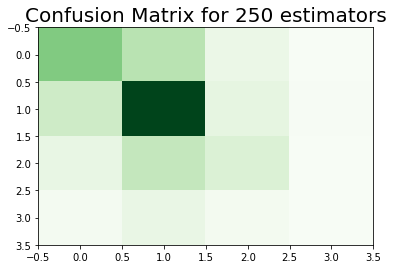

AUC Score Weighted 0.7387784361661855
AUC Score Micro 0.8099361016002222
AUC Score Macro 0.7256606128346261
              precision    recall  f1-score   support

           0      0.567     0.546     0.557      9110
           1      0.602     0.740     0.664     14424
           2      0.412     0.310     0.354      5775
           3      0.150     0.020     0.035      1785

    accuracy                          0.562     31094
   macro avg      0.433     0.404     0.402     31094
weighted avg      0.530     0.562     0.539     31094

Runtime: 00:01:23


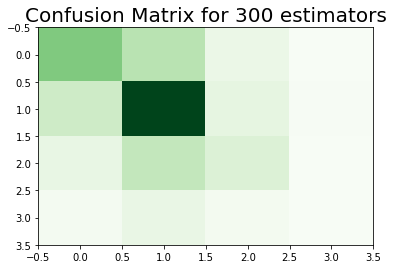

AUC Score Weighted 0.7391762899715427
AUC Score Micro 0.8103362321968186
AUC Score Macro 0.7255048746945245
              precision    recall  f1-score   support

           0      0.568     0.548     0.558      9110
           1      0.602     0.741     0.664     14424
           2      0.411     0.309     0.353      5775
           3      0.164     0.020     0.036      1785

    accuracy                          0.563     31094
   macro avg      0.436     0.404     0.403     31094
weighted avg      0.531     0.563     0.539     31094

Runtime: 00:01:39


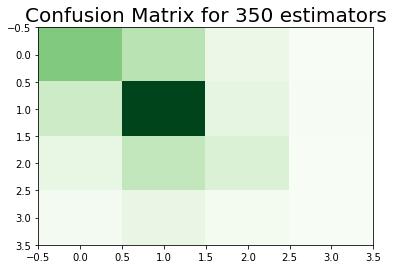

AUC Score Weighted 0.7393706783718356
AUC Score Micro 0.8104565394665345
AUC Score Macro 0.7258145693279754
              precision    recall  f1-score   support

           0      0.570     0.550     0.560      9110
           1      0.602     0.741     0.664     14424
           2      0.412     0.310     0.354      5775
           3      0.159     0.021     0.037      1785

    accuracy                          0.563     31094
   macro avg      0.436     0.405     0.404     31094
weighted avg      0.532     0.563     0.540     31094

Runtime: 00:01:59


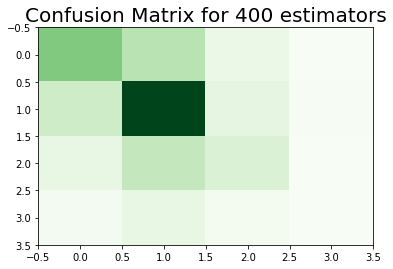

AUC Score Weighted 0.7393527008934103
AUC Score Micro 0.8103408675877137
AUC Score Macro 0.7259101018104165
              precision    recall  f1-score   support

           0      0.571     0.550     0.560      9110
           1      0.603     0.742     0.665     14424
           2      0.412     0.309     0.353      5775
           3      0.154     0.020     0.035      1785

    accuracy                          0.564     31094
   macro avg      0.435     0.405     0.403     31094
weighted avg      0.532     0.564     0.540     31094

Runtime: 00:02:14


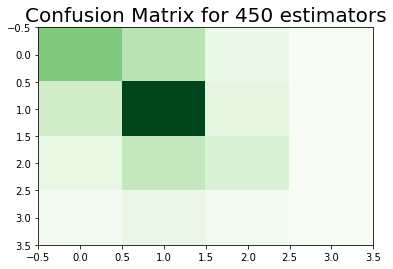

AUC Score Weighted 0.7398518894012154
AUC Score Micro 0.8107164669854732
AUC Score Macro 0.7270464001561913
              precision    recall  f1-score   support

           0      0.571     0.550     0.560      9110
           1      0.604     0.743     0.666     14424
           2      0.413     0.311     0.354      5775
           3      0.157     0.021     0.037      1785

    accuracy                          0.565     31094
   macro avg      0.436     0.406     0.404     31094
weighted avg      0.533     0.565     0.541     31094

Runtime: 00:02:39


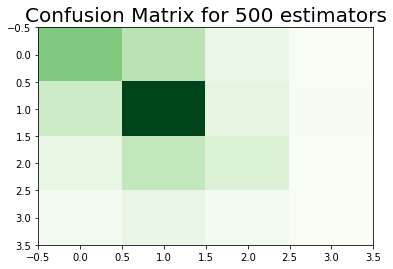

AUC Score Weighted 0.7396852849665495
AUC Score Micro 0.8105424350353706
AUC Score Macro 0.7264483573510858
              precision    recall  f1-score   support

           0      0.571     0.549     0.560      9110
           1      0.602     0.742     0.665     14424
           2      0.412     0.308     0.352      5775
           3      0.172     0.022     0.040      1785

    accuracy                          0.564     31094
   macro avg      0.439     0.405     0.404     31094
weighted avg      0.533     0.564     0.540     31094

Runtime: 00:02:50
Best accuracy is  0.5646105357946871  with  450  Estimators in a Raw Random Forest
              precision    recall  f1-score   support

           0      0.571     0.550     0.560      9110
           1      0.604     0.743     0.666     14424
           2      0.413     0.311     0.354      5775
           3      0.157     0.021     0.037      1785

    accuracy                          0.565     31094
   macro avg      0.436     0.

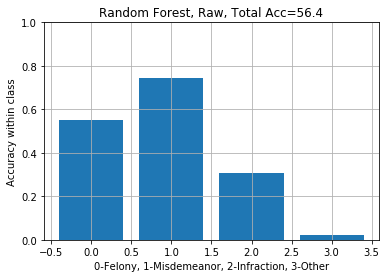

Wall time: 15min 20s


In [99]:
%%time
if RUN_RF4:
    from sklearn.ensemble import RandomForestClassifier
    maxAccRF = 0
    optimalEstimatorsRF = 0
    clReport = ''

    for i in range(100, 501, 50):
        rfTime = time.time()
        clf = RandomForestClassifier(n_estimators=i, n_jobs=-1, oob_score=True)

        # now iterate through and get predictions, saved to the correct row in yhat
        for train, test in cv.split(Xd,yd):
            clf.fit(Xd[train],yd[train])
            yhatd[test] = clf.predict(Xd[test])
            yhatd_score[test] = clf.predict_proba(Xd[test])

        total_accuracy = mt.accuracy_score(yd, yhatd)

        plt.title('Confusion Matrix for {0} estimators'.format(i), fontsize = 20)
        plt.imshow(mt.confusion_matrix(yd, yhatd),cmap=plt.get_cmap('Greens'),aspect='auto')
        plt.grid(False)
        plt.show()

        if total_accuracy > maxAccRF:
            maxAccRF = total_accuracy
            optimalEstimatorsRF = i
            optimalYRF = yd
            optimalYhatRF = yhatd
            clReport = mt.classification_report(yd,yhatd,digits=3)

        lb=LabelBinarizer()
        lb.fit(yd)
        yd_lb = lb.transform(yd)
        yhatd_lb = lb.transform(yhatd)
        print ('AUC Score Weighted', roc_auc_score(yd_lb, yhatd_score, average='weighted', multi_class='ovr'))
        print ('AUC Score Micro', roc_auc_score(yd_lb, yhatd_score, average='micro', multi_class='ovr'))
        print ('AUC Score Macro', roc_auc_score(yd_lb, yhatd_score, average='macro', multi_class='ovr'))
        
        print (mt.classification_report(yd, yhatd, digits = 3))

        endTime = time.time() - rfTime
        seconds = int(abs(endTime % 60))
        allMinutes = int(abs(endTime / 60))
        minutes = int(abs(allMinutes % 60))
        allHours = int(abs(allMinutes / 60))
        hours = int(abs(allMinutes / 60))
        print ("Runtime: %02d:%02d:%02d" % (hours, minutes, seconds))

    print ('Best accuracy is ', maxAccRF, ' with ', optimalEstimatorsRF, ' Estimators in a Raw Random Forest')
    print(clReport)
    plot_class_acc(optimalYRF,optimalYhatRF,title="Random Forest, Raw")

#### Random Forest Performance for Descent Code

`Table 8` shows the results for the random forest models for `Descent Code`.

The winning model is again without PCA, but this time using 450 estimators. The Micro AUC is 80.971%.

Accuracy for both variations, with and without PCA, was barely over .5 across all estimators. Random forest is clearly not the best model for descent code, so we will look to other models for this variable.

#### Table 8: Random Forest Performance for Descent Code
Performance metrics for each Descent Code are listed as *Precision, Recall*.

| PCA | Estimators | Time | Accuracy | Micro AUC | Black | Hispanic | White | Other | 
| :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- |
| 50 | 100 | 01:22 | 54.2% | 79.389% | 55.7%, 46.7% | 54.9%, 81.8% | 42.9%, 13.9% | 9.0%, 0.6% |
| 50 | 150 | 02:02 | 54.7% | 79.656% | 57.2%, 47.3% | 55.1%, 82.2% | 42.9%, 14.1% | 11.3%, 0.7% |
| 50 | 200 | 02:40 | 54.6% | 79.833% | 57.2%, 46.6% | 55.0%, 82.6% | 42.9%, 13.9% | 9.3%, 0.6% |
| 50 | 250 | 03:14 | 54.6% | 79.824% | 57.4%, 46.8% | 54.9%, 82.8% | 42.8%, 13.4% | 11.0%, 0.6% |
| 50 | 300 | 03:53 | 54.6% | 79.873% | 57.7%, 46.6% | 54.8%, 82.8% | 42.4%, 13.4% | 10.1%, 0.6% |
| 50 | 350 | 04:28 | 54.6% | 79.960% | 57.8%, 46.4% | 54.7%, 83.0% | 43.3%, 13.2% | 10.8%, 0.7% |
| 50 | 400 | 05:11 | 54.5% | 79.974% | 57.1%, 46.3% | 54.8%, 82.7% | 43.4%, 13.9% | 10.2%, 0.6% |
| 50 | 450 | 05:35 | 54.6% | 79.933% | 57.1%, 46.0% | 54.8%, 82.9% | 44.3%, 13.9% | 10.4%, 0.6% |
| 50 | 500 | 05:54 | 54.6% | 80.065% | 57.6%, 46.8% | 54.8%, 82.7% | 43.3%, 13.7% | 9.7%, 0.6% |
| NA | 100 | 00:33 | 56.1% | 80.801% | 56.4%, 55.1% | 60.2%, 73.6% | 40.8%, 30.3% | 15.3%, 2.1% |
| NA | 150 | 00:51 | 56.4% | 80.971% | 56.9%, 55.0% | 60.3%, 74.0% | 41.4%, 31.4% | 16.5%, 2.1% |
| NA | 200 | 01:09 | 56.3% | 80.927% | 56.9%, 55.0% | 60.3%, 74.2% | 40.8%, 30.5% | 15.5%, 2.0% |
| NA | 250 | 01:23 | 56.2% | 80.994% | 56.7%, 54.6% | 60.2%, 74.0% | 41.2%, 31.0% | 15.0%, 2.0% |
| NA | 300 | 01:39 | 56.3% | 81.034% | 56.8%, 54.8% | 60.2%, 74.1% | 41.1%, 30.9% | 16.4%, 2.0% |
| NA | 350 | 01:59 | 56.3% | 81.046% | 57.0%, 55.0% | 60.2%, 74.1% | 41.2%, 31.0% | 15.9%, 2.1% |
| NA | 400 | 02:14 | 56.4% | 81.034% | 57.1%, 55.0% | 60.3%, 74.2% | 41.2%, 30.9% | 15.4%, 2.0% |
| **NA** | **450** | **02:39** | **56.5%** | **81.072%** | **57.1%, 55.0%** | **60.4%, 74.3%** | **41.3%, 31.1%** | **15.7%, 2.1%** |
| NA | 500 | 02:50 | 56.4% | 81.054% | 57.1%, 54.9% | 60.2%, 74.2% | 41.2%, 30.8% | 17.2%, 2.2% |

<a href='#Section_0'> Back to top </a>  
<a id = 'Section_7_b_4'></a>

### SVM - Descent Code

In [65]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt

# create variables we are more familiar with
if 'Descent Code' in df_descent2:
    ydS = df_descent2['Descent Code'].values # get the labels we want
    del df_descent2['Descent Code'] # get rid of the class label
    XdS = df_descent2.values # use everything else to predict!
    
yhatdS = np.zeros(ydS.shape) # we will fill this with predictions
yhatdS_score = np.zeros((ydS.shape[0],4))

scl = StandardScaler()
XdS = scl.fit_transform(XdS)

# create cross validation iterator
cv = StratifiedKFold(n_splits=10, random_state=1234)

In [66]:
def SVMd(krnl):
    for train, test in cv.split(XdS,ydS):
        svm_clf = SVC(C=0.5, kernel=krnl, degree=3, gamma='auto',probability=True).fit(XdS[train], ydS[train])
        yhatdS[test] = svm_clf.predict(XdS[test])
        yhatdS_score[test] = svm_clf.predict_proba(XdS[test])

    lb=LabelBinarizer()
    lb.fit(ydS)
    ydS_lb = lb.transform(ydS)
    yhatdS_lb = lb.transform(yhatdS)
    print ('AUC Score Weighted', roc_auc_score(ydS_lb, yhatdS_score, average='weighted', multi_class='ovr'))
    print ('AUC Score Micro', roc_auc_score(ydS_lb, yhatdS_score, average='micro', multi_class='ovr'))
    print ('AUC Score Macro', roc_auc_score(ydS_lb, yhatdS_score, average='macro', multi_class='ovr'))

    print (mt.classification_report(ydS,yhatdS,digits=3))

    plot_class_acc(ydS,yhatdS,title="SVM")

#### SVM Sigmoid Kernel

In [67]:
%%time
if RUN_SVM3:
    krnl='sigmoid'
    SVMd(krnl)

Wall time: 0 ns


#### SVM Linear Kernel

In [68]:
%%time
if RUN_SVM3:
    krnl='linear'
    SVMd(krnl)

Wall time: 0 ns


#### SVM Polynomial Kernel

In [69]:
%%time
if RUN_SVM4:
    krnl='poly'
    SVMd(krnl)

Wall time: 0 ns


#### SVM Radial Basis Function Kernel

In [70]:
%%time
if RUN_SVM4:
    krnl='rbf'
    SVMd(krnl)

Wall time: 0 ns


#### Stochastic Gradient Descent

In [ ]:
%%time
# Linear SVM classifier with Stochastic Descent
if RUN_SGD4:
    from sklearn.linear_model import SGDClassifier

    regularize_const = 0.1
    iterations = 5

    for train, test in cv.split(Xd,yd):
        svm_clf = svm_sgd = SGDClassifier(alpha=regularize_const,
            fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
            loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2').fit(Xd[train], yd[train])
        yhata[test] = svm_clf.predict(Xd[test])
        yhatd_score[test] = lgbm_model.predict_proba(Xd[test])

    lb=LabelBinarizer()
    lb.fit(yd)
    yd_lb = lb.transform(yd)
    yhatd_lb = lb.transform(yhatd)
    print ('AUC Score Weighted', roc_auc_score(yd_lb, yhatd_score, average='weighted', multi_class='ovr'))
    print ('AUC Score Micro', roc_auc_score(yd_lb, yhatd_score, average='micro', multi_class='ovr'))
    print ('AUC Score Macro', roc_auc_score(yd_lb, yhatd_score, average='macro', multi_class='ovr'))

    print (mt.classification_report(yd,yhatd,digits=3))

    plot_class_acc(yd,yhatd,title="SGD")

#### SVM Performance for Descent Code

`Table 9` shows the results for the SVM and SGD models for `Descent Code`.

The winning model here is with the rbf kernel. The AUC score is 65.786% for this model. It is interesting to note that the winning kernel for `Arrest Type Code` was linear, not rbf.

Again processing time for these models is significant, with the rbf model taking 2:18:23 for just 5% of the data. SGD reduces the time drastically, but there is a large decrease in the AUC score.

#### Table 9: SVM Performance for Descent Code
Performance metrics for each Descent Code are listed as *Precision, Recall*.

| Kernel | Time | Accuracy | AUC | Felony | Misdemeanor | Infraction | Other | 
| :-- | :-- | :-- | :-- | :-- | :-- | :-- | :-- |
| sigmoid | 1:25:09 | 52.2% | 61.895% | 51.5%, 51.6% | 57.2%, 67.7% | 36.0%, 30.8% | 00.0%, 00.0% |
| linear | 3:41:08 | 55.0% | 62.584% | 56.8%, 57.2% | 56.1%, 74.9% | 40.7%, 18.1% | 00.0%, 00.0% |
| polynomial | 2:34:57 | 57.7% | 65.294% | 57.8%, 61.6% | 59.8%, 76.4% | 45.8%, 22.9% | 13.9%, 00.6% |
| **rbf** | **2:18:23** | **58.2%** | **65.876%** | **58.8%, 61.2%** | **60.4%, 76.0%** | **45.7%, 27.5%** | **00.0%, 00.0%** |
| SGD | 0:00:06 | 29.4% | 50.000% | 29.4%, 100.0% | 00.0%, 00.0% | 00.0%, 00.0% | 00.0%, 00.0% |

<a href='#Section_0'> Back to top </a>  
<a id = 'Section_8'></a>

## 8. AUC Plot

An AUC plot can help us visually evaluate the quality of a classification model. The ROC curve summarizes the confusion matrices that each threshhold produced. A curve above and to the left of the "Luck" like indicates a model that does better than random chance, i.e., a significant model. 

We plotted the ROC curve for each class and the ROC curve that aggregates the performance of each curve (micro-average ROC curve). The individual curves let us know how well the model classifies that particlar class and the micro-average ROC curve lets us know how the model performs as a whole.

We used the micro-average as it is more appropriate for a dataset with imbalanced classes as we have. The micro average will pool the performance over all samples as opposed to the macro average which will average the performance over the number of members in each class. The micro average AUC is less sensitive to class imbalance.

Per the scikit-learn documentation, "ROC curves are typically used in binary classification to study the output of a classifier. In order to extend ROC curve and ROC area to multi-label classification, it is necessary to binarize the output. One ROC curve can be drawn per label, but one can also draw a ROC curve by considering each element of the label indicator matrix as a binary prediction (micro-averaging)."

We have displayed the micro-averaged ROC curve for the winning models for each classification task along with the ROC curves for each class. For the Arrest Type classification task the winning model does a better job of classifying Infraction and Other arrest types, classes 2 and 3 respectively. For the Descent Code classification task, that winning model does a better job of identifying class 0, i.e., the "White" descent code. We did notice an unusual micro-average ROC curve for this task that appears to extend beyond the rest of the curves; however, we did not have enough time to thoroughly research this peculiarity before submission of the project. 

In [160]:
%%time

import lightgbm as lgb
import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Create empty array for predicted probabilites. Since we have 4 classes, we have one
# probability for each class
yhata = np.zeros(ya.shape)
yhata_score = np.zeros((ya.shape[0],4))

for train, test in cv.split(Xa,ya):
    lgbm_model = lgb.LGBMClassifier(n_estimators = 1000,
                                    objective = 'multiclass',
                                    learning_rate = 0.05,
                                    num_leaves = 31,
                                    lambda_l1 = 0.05,
                                    lambda_l2 = 0.05, 
                                    maxdepth = 2,
                                    bagging_fraction = 1.0,
                                    nthread =  0,
                                    min_gain_to_split = 0.02,
                                    feature_fraction = 0.8,
                                    random_state = 17).fit(Xa[train], ya[train])
    yhata[test] = lgbm_model.predict(Xa[test])
    yhata_score[test] = lgbm_model.predict_proba(Xa[test])

lb=LabelBinarizer()
lb.fit(ya)
ya_lb = lb.transform(ya)
yhata_lb = lb.transform(yhata)
print ('AUC Score Weighted', roc_auc_score(ya_lb, yhata_score, average='weighted', multi_class='ovr'))
print ('AUC Score Micro', roc_auc_score(ya_lb, yhata_score, average='micro', multi_class='ovr'))
print ('AUC Score Macro', roc_auc_score(ya_lb, yhata_score, average='macro', multi_class='ovr'))

AUC Score Weighted 0.9057207431729554
AUC Score Micro 0.9626673550392806
AUC Score Macro 0.9292791767003392
Wall time: 2min 54s


In [161]:
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

# code manipulated from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html?highlight=roc

def roc_curve(actuals, predictions):
    # Compute ROC curve for all classes
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    thresh = dict()
    for i in np.unique(actuals):
        fpr[i], tpr[i], thresh[i] = mt.roc_curve(actuals, predictions[:, i], pos_label=i)
        roc_auc[i] = mt.auc(fpr[i], tpr[i])

    # Combined ROC over all classes
    one_hot_class_encoding = label_binarize(actuals,np.unique(actuals))
    fpr["micro"], tpr["micro"], thresh["micro"] = mt.roc_curve(one_hot_class_encoding.ravel(), predictions.ravel())
    roc_auc["micro"] = mt.auc(fpr["micro"], tpr["micro"])

    n_classes = 4

    # Aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(8,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (AUC = {0:0.3f})'
                   ''.format(roc_auc["micro"]),
             color='#7AC74F', linestyle=':', linewidth=4)


    colors = cycle(['#d42920', '#32312b', '#fac22b', '#0d638e'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve for  class {0} (AUC = {1:0.3f})'
                 ''.format(i, roc_auc[i]))

    # Plot the "Luck" line
    plt.plot(
            [0, 1], [0, 1],
            linestyle='--',
            lw=2,
            color='black',
            label='Luck',
            alpha=.8)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-average ROC Curve and ROC curves by Class')
    plt.legend(loc="lower right")
    plt.show()

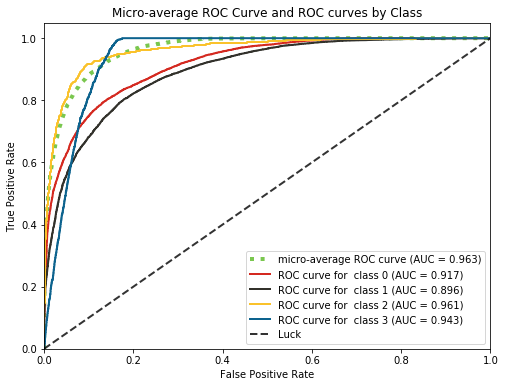

In [163]:
roc_curve(ya, yhata_score)

In [165]:
%%time
import lightgbm as lgb

# Create empty array for predicted probabilites. Since we have 4 classes, we have one
# probability for each class
yhatd = np.zeros(yd.shape)
yhatd_score = np.zeros((yd.shape[0],4))

for train, test in cv.split(Xd,yd):
    lgbm_model = lgb.LGBMClassifier(n_estimators = 100,
                                    objective = 'multiclass',
                                    learning_rate = 0.1,
                                    num_leaves = 31,
                                    lambda_l1 = 0,
                                    lambda_l2 = 0, 
                                    maxdepth = -1,
                                    bagging_fraction = 1.0,
                                    nthread = 0,
                                    min_gain_to_split = 0,
                                    feature_fraction = 1.0,
                                    random_state = 17).fit(Xd[train], yd[train])
    yhatd[test] = lgbm_model.predict(Xd[test])
    yhatd_score[test] = lgbm_model.predict_proba(Xd[test])

lb=LabelBinarizer()
lb.fit(yd)
yd_lb = lb.transform(yd)
yhatd_lb = lb.transform(yhatd)
print ('AUC Score Weighted', roc_auc_score(yd_lb, yhatd_score, average='weighted', multi_class='ovr'))
print ('AUC Score Micro', roc_auc_score(yd_lb, yhatd_score, average='micro', multi_class='ovr'))
print ('AUC Score Macro', roc_auc_score(yd_lb, yhatd_score, average='macro', multi_class='ovr'))

AUC Score Weighted 0.7682034256984299
AUC Score Micro 0.8305708007876396
AUC Score Macro 0.7591895300410373
Wall time: 1min 4s


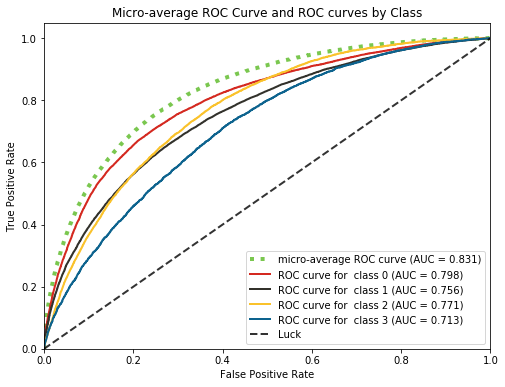

In [166]:
roc_curve(yd, yhatd_score)

<a href='#Section_0'> Back to top </a>  
<a id = 'Section_9'></a>

## 9. Model Comparison

#### Table 10: Classifying Arrest Type Code
*(Parameters that are different than the defaults are listed)*

| Winning Model by Type | Time | AUC | 
| :-- | :-- | :-- | 
| XGBoost - tree_method='hist' | 1:47 | 79.186% |
| LightGBM | 
| Random Forest | 
| SVM | 

#### Table 11: Classifying Descent Code
*(Parameters that are different than the defaults are listed)*

| Winning Model by Type | Time | AUC | 
| :-- | :-- | :-- | 
| XGBoost - tree_method='hist', max_depth=7 | 2:08 | 66.215% |
| LightGBM | 
| Random Forest | 
| SVM | 

(ROC/AUC) was chosen as the comparison metric for the 3 models on both tasks because (reasons go here). 

For classifying arrest code, the (winning model type) achieved a final ROC of (roc here),  (slightly/much) larger  compared to the others. This may be due to the unbalanced nature of the data; 60% misdemeanors, 30% felonies, less than 10% infractions and other.  This may fit the structural and computational assumptions of (winning model) better than (losing models). (evidence to back that up)

For Classifying Descent Code, the (winning model type) had a final ROC of (ROC here), (much/ only marginally) better than (the other two, with (roc2, roc3)). Descent code was also a fairly unbalanced dataset, with almost 50% of the arrests recorded as Hispanic, 30% black, and 15% white. (winning model) operates on (assumptions of winning model) which are more closely reflected in the data than (the assumptions of the other models).  

<a href='#Section_0'> Back to top </a>  
<a id = 'Section_10'></a>

## 10. Important Variables

AUC Score Weighted 0.9057207431729554
AUC Score Micro 0.9626673550392806
AUC Score Macro 0.9292791767003392
              precision    recall  f1-score   support

           0      0.796     0.747     0.771     10624
           1      0.822     0.893     0.856     19075
           2      0.725     0.350     0.472       708
           3      0.266     0.025     0.045       687

    accuracy                          0.811     31094
   macro avg      0.652     0.504     0.536     31094
weighted avg      0.799     0.811     0.800     31094



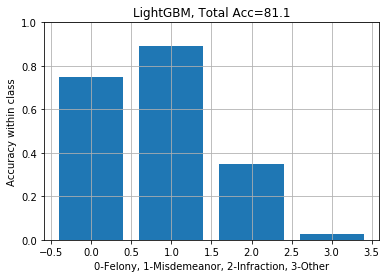

Wall time: 2min 51s


In [167]:
%%time

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt
import pickle
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, roc_auc_score
import eli5
from eli5.sklearn import PermutationImportance

for train, test in cv.split(Xa,ya):
    lgbm_model = lgb.LGBMClassifier(n_estimators = 1000,
                                    objective = 'multiclass',
                                    learning_rate = 0.05,
                                    num_leaves = 31,
                                    lambda_l1 = 0.05,
                                    lambda_l2 = 0.05, 
                                    maxdepth = 2,
                                    bagging_fraction = 1.0,
                                    nthread =  0,
                                    min_gain_to_split = 0.02,
                                    feature_fraction = 0.8,
                                    random_state = 17).fit(Xa[train], ya[train])
    yhata[test] = lgbm_model.predict(Xa[test])
    yhata_score[test] = lgbm_model.predict_proba(Xa[test])

lb=LabelBinarizer()
lb.fit(ya)
ya_lb = lb.transform(ya)
yhata_lb = lb.transform(yhata)
print ('AUC Score Weighted', roc_auc_score(ya_lb, yhata_score, average='weighted', multi_class='ovr'))
print ('AUC Score Micro', roc_auc_score(ya_lb, yhata_score, average='micro', multi_class='ovr'))
print ('AUC Score Macro', roc_auc_score(ya_lb, yhata_score, average='macro', multi_class='ovr'))

print (mt.classification_report(ya, yhata, digits = 3))

plot_class_acc(ya, yhata, title = "LightGBM")

lgb_weights = eli5.show_weights(lgbm_model, feature_names = list(df_arrest1.columns), top=20)

In [168]:
lgb_weights

AUC Score Weighted 0.7682034256984299
AUC Score Micro 0.8305708007876396
AUC Score Macro 0.7591895300410373
              precision    recall  f1-score   support

           0      0.607     0.595     0.601     17564
           1      0.613     0.769     0.682     27659
           2      0.466     0.326     0.384     11079
           3      0.375     0.009     0.017      3494

    accuracy                          0.592     59796
   macro avg      0.515     0.425     0.421     59796
weighted avg      0.570     0.592     0.564     59796



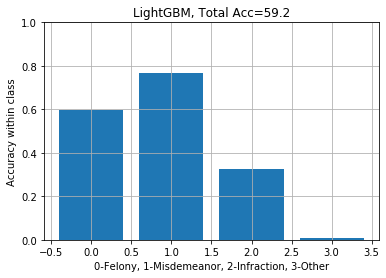

Wall time: 1min 7s


In [170]:
%%time
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt
import pickle
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, roc_auc_score
import eli5
from eli5.sklearn import PermutationImportance

for train, test in cv.split(Xd,yd):
    lgbm_model = lgb.LGBMClassifier(n_estimators = 100,
                                        objective = 'multiclass',
                                        learning_rate = 0.1,
                                        num_leaves = 31,
                                        lambda_l1 = 0,
                                        lambda_l2 = 0, 
                                        maxdepth = -1,
                                        bagging_fraction = 1.0,
                                        nthread = 0,
                                        min_gain_to_split = 0,
                                        feature_fraction = 1.0,
                                        random_state = 17).fit(Xd[train], yd[train])
    yhatd[test] = lgbm_model.predict(Xd[test])
    yhatd_score[test] = lgbm_model.predict_proba(Xd[test])

lb=LabelBinarizer()
lb.fit(yd)
yd_lb = lb.transform(yd)
yhatd_lb = lb.transform(yhatd)
print ('AUC Score Weighted', roc_auc_score(yd_lb, yhatd_score, average='weighted', multi_class='ovr'))
print ('AUC Score Micro', roc_auc_score(yd_lb, yhatd_score, average='micro', multi_class='ovr'))
print ('AUC Score Macro', roc_auc_score(yd_lb, yhatd_score, average='macro', multi_class='ovr'))

print (mt.classification_report(yd, yhatd, digits = 3))

plot_class_acc(yd, yhatd, title = "LightGBM")

lgb_weights = eli5.show_weights(lgbm_model, feature_names = list(df_arrest1.columns), top=20)

In [171]:
lgb_weights

<a id = 'Section_11'></a>

## 11. Deployment

Although minority report style real time predictive modeling is the most impactful use of this type of analysis, the amount of cleaning necessary to process the data would likely make this process too cumbersome to execute in real time for a single county, let alone large municipalities. Pending advances in data processing speeds, massive funding increases for police departments, and/or some drastic changes in presumption of innocence, the next best use of this process would be retrospective data analysis. 

Possible uses would be obtaining relevant analysis on things that could influence anything intersecting the data gathered during the arrests. Changes in demographic, criminal definition, and almost anything on a macro-sociological scale if you abstract out far enough it could possibly be reflected in an expanded database of arrests. The ability to condense wide-scale sociological change into easily understandable and verifiable conclusions would be the primary function of this type of retrospective analysis, although the findings would necessarily be limited by the type of information put into the database. Conclusions like “The new highschool police mentorship program in this county has reduced arrests in high school age people by 15% ” or “This new Spanish-language program for officers has reduced hispanic misdemeanors by 10%” would be valuable information for citizens, politicians, and civil servants who have influence in the process of creating/implementing such civil programs.

Additional data that would be benecficial would include median income by area, which would give additional insights into factors influencing arrest types. Deployment of the model could be real-time classification of potential arrest types to dispatch appropriate policing resources. The model would need to be updated weekly as that is the frequency with which the L.A. City Arrest Data is updated.

<a href='#Section_0'> Back to top </a>  
<a id = 'Section_12'></a>

## 12. Additional Analysis

### Model Performance Comparison at Different Sample Sizes

The size of our dataset has been problematic throught modeling due to the time required to process the full dataset. A 5% run of all models takes approximately 20 hours. We researched various methods for parallel processing, but were not successful in setting that up. What we ended up doing was splitting the load and processing parts of the workbook on differetn machines. Edward had 4 machines he could run on, which reduced the critical path down to 10 hours (with SVM being the critical path). 

We decided to stay with using 5% of the data. This lead us to question what the performance would have been if we used a different sample size. The code that follows is running the winning `Arrest Type Code` model at different sample sizes. A table with results follows.

In [81]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt
import pickle
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, roc_auc_score

def LightGBMa(estimators, l_rate, leaves, r_alpha, r_lambda, depth, subsample, thread, split_gain, colsample,samplesize):
    df_arrest1 = df_arrest

    #subsample of dataframe
    df_arrest1 = pd.DataFrame.sample(df_arrest1, frac = samplesize, random_state = 34128)

    print("The datasets have {:,} rows and {:,} columns".format(*df_arrest1.shape))

    # create variables we are more familiar with
    if 'Arrest Type Code' in df_arrest1:
        ya = df_arrest1['Arrest Type Code'].values # get the labels we want
        del df_arrest1['Arrest Type Code'] # get rid of the class label
        Xa = df_arrest1.values # use everything else to predict!

    yhata = np.zeros(ya.shape) # we will fill this with predictions

    scl = StandardScaler()
    Xa = scl.fit_transform(Xa)

    # create cross validation iterator
    cv = StratifiedKFold(n_splits=10, random_state=1234)

    for train, test in cv.split(Xa,ya):
        lgbm_model = lgb.LGBMClassifier(n_estimators = estimators,
                                        objective = 'multiclass',
                                        learning_rate = l_rate,
                                        num_leaves = leaves,
                                        lambda_l1 = r_alpha,
                                        lambda_l2 = r_lambda, 
                                        maxdepth = depth,
                                        bagging_fraction = subsample,
                                        nthread = thread,
                                        min_gain_to_split = split_gain,
                                        feature_fraction = colsample,
                                        random_state = 17).fit(Xa[train], ya[train])
        yhata[test] = lgbm_model.predict(Xa[test])
    
    lb = LabelBinarizer()
    lb.fit(ya)
    ya_lb = lb.transform(ya)
    yhata_lb = lb.transform(yhata)
    print ('AUC Score', roc_auc_score(ya_lb, yhata_lb, average = 'weighted'))

In [82]:
%%time
if RUN_EXTRA1:
    estimators = 10000
    objective = 'multiclass'
    l_rate = 0.05
    leaves = 34
    r_alpha = 0.05
    r_lambda = 0.05
    depth = 7
    subsample = 1.0
    thread = 0
    split_gain = 0.02
    colsample = 0.8
    samplesize=.01

    LightGBMa(estimators, l_rate, leaves, r_alpha, r_lambda, depth, subsample, thread, split_gain, colsample, samplesize)

The datasets have 11,959 rows and 87 columns
AUC Score 0.792345602384455
Wall time: 14min 32s


In [83]:
%%time
if RUN_EXTRA1:
    estimators = 10000
    objective = 'multiclass'
    l_rate = 0.05
    leaves = 34
    r_alpha = 0.05
    r_lambda = 0.05
    depth = 7
    subsample = 1.0
    thread = 0
    split_gain = 0.02
    colsample = 0.8
    samplesize=.10

    LightGBMa(estimators, l_rate, leaves, r_alpha, r_lambda, depth, subsample, thread, split_gain, colsample, samplesize)

The datasets have 119,593 rows and 87 columns
AUC Score 0.7997509474786634
Wall time: 1h 30min 50s


In [84]:
%%time
if RUN_EXTRA2:
    estimators = 10000
    objective = 'multiclass'
    l_rate = 0.05
    leaves = 34
    r_alpha = 0.05
    r_lambda = 0.05
    depth = 7
    subsample = 1.0
    thread = 0
    split_gain = 0.02
    colsample = 0.8
    samplesize=.20

    LightGBMa(estimators, l_rate, leaves, r_alpha, r_lambda, depth, subsample, thread, split_gain, colsample, samplesize)

The datasets have 239,185 rows and 87 columns
AUC Score 0.8011336147861854
Wall time: 1h 16min 46s


In [87]:
%%time
if RUN_EXTRA5:
    estimators = 10000
    objective = 'multiclass'
    l_rate = 0.05
    leaves = 34
    r_alpha = 0.05
    r_lambda = 0.05
    depth = 7
    subsample = 1.0
    thread = 0
    split_gain = 0.02
    colsample = 0.8
    samplesize=.50

    LightGBMa(estimators, l_rate, leaves, r_alpha, r_lambda, depth, subsample, thread, split_gain, colsample, samplesize)

The datasets have 597,963 rows and 87 columns
AUC Score 0.8022307821907829
Wall time: 2h 38min 2s


#### Table 12: LightGBM Arrest Type Code Winning Model - Sample Size performance Comparison

| Sample % | Record Count | AUC | Time (HH:MM:SS) | 
| :-- | :-- | :-- | :-- |
| 1% | 11,959 | 79.235% | 0:14:32 |
| 10% | 119,593 | 79.795% | 1:30:50 | 
| 20% | 239,185 | 80.113% | 1:16:46 |
| 30% | 358,778 |  |  |
| 40% | 478,370 |  |  |
| 50% | 597,963 | 80.223% | 2:38:02 |
| 60% | 717,556 |  |  |

`Table 12` shows that there are improvements in AUC up through a sample size of 30%. Increases of 10% after that do not have a large impact on AUC. 30% would be the preferable sample size. However, in our case the critical path is SVM not LightGBM. We thought it best to compare all models on the exact same sample size.

### Grid Search for KNN classifier (Arrest Type Code)

In [89]:
#sampling data for time constraints
if RUN_OTHER:
    df_arrest_small = pd.DataFrame.sample(df_arrest, frac = .025, random_state = 1234)
    len(df_arrest_small)

31929

In [90]:
%%time
if RUN_OTHER:
    #multi parameter grid search

    k_range = list(range(1, 25))
    weight_options = ['uniform', 'distance']

    param_grid = dict(n_neighbors = k_range, weights = weight_options)
    print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 'weights': ['uniform', 'distance']}
Wall time: 0 ns


In [91]:
%%time
if RUN_OTHER:
    grid = GridSearchCV(knn, param_grid, cv = 10, scoring = 'accuracy', return_train_score = False)
    grid.fit(X, y)
    results = pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
    results.sort_values(by = ["mean_test_score"], ascending = False)

Wall time: 1h 28min 42s


mean_test_score  std_test_score  \
46         0.757869        0.006855   
38         0.757399        0.005321   
30         0.757149        0.006903   
47         0.756835        0.006759   
40         0.756804        0.006361   
42         0.756742        0.006156   
39         0.756554        0.005718   
43         0.756303        0.005521   
34         0.756240        0.006939   
41         0.756240        0.006925   
45         0.756084        0.008087   
44         0.755927        0.007919   
35         0.755395        0.007158   
31         0.755238        0.007501   
26         0.754706        0.005845   
33         0.754612        0.006485   
37         0.754612        0.006496   
32         0.753985        0.006669   
36         0.753829        0.006808   
27         0.753672        0.006504   
29         0.753610        0.007732   
28         0.753484        0.007049   
25         0.751699        0.007289   
22         0.751668        0.005274   
24         0.751417        0.007543   
23         0.750102        0.005085   
18         0.748567        0.006882   
19         0.748317        0.007884   
21         0.747408        0.006187   
20         0.747001        0.006503   
16         0.744120        0.006630   
17         0.743901        0.005300   
14         0.743838        0.007281   
15         0.743212        0.006548   
13         0.737417        0.008434   
12         0.736822        0.008837   
10         0.735444        0.007082   
11         0.734881        0.007118   
9          0.728805        0.006845   
8          0.728116        0.007738   
7          0.722478        0.009040   
6          0.721538        0.008385   
5          0.712769        0.010300   
4          0.711266        0.010692   
3          0.677253        0.008496   
2          0.673181        0.008741   
1          0.671740        0.009149   
0          0.671740        0.009149   

                                        params  
46   {'n_neighbors': 24, 'weights': 'uniform'}  
38   {'n_neighbors': 20, 'weights': 'uniform'}  
30   {'n_neighbors': 16, 'weights': 'uniform'}  
47  {'n_neighbors': 24, 'weights': 'distance'}  
40   {'n_neighbors': 21, 'weights': 'uniform'}  
42   {'n_neighbors': 22, 'weights': 'uniform'}  
39  {'n_neighbors': 20, 'weights': 'distance'}  
43  {'n_neighbors': 22, 'weights': 'distance'}  
34   {'n_neighbors': 18, 'weights': 'uniform'}  
41  {'n_neighbors': 21, 'weights': 'distance'}  
45  {'n_neighbors': 23, 'weights': 'distance'}  
44   {'n_neighbors': 23, 'weights': 'uniform'}  
35  {'n_neighbors': 18, 'weights': 'distance'}  
31  {'n_neighbors': 16, 'weights': 'distance'}  
26   {'n_neighbors': 14, 'weights': 'uniform'}  
33  {'n_neighbors': 17, 'weights': 'distance'}  
37  {'n_neighbors': 19, 'weights': 'distance'}  
32   {'n_neighbors': 17, 'weights': 'uniform'}  
36   {'n_neighbors': 19, 'weights': 'uniform'}  
27  {'n_neighbors': 14, 'weights': 'distance'}  
29  {'n_neighbors': 15, 'weights': 'distance'}  
28   {'n_neighbors': 15, 'weights': 'uniform'}  
25  {'n_neighbors': 13, 'weights': 'distance'}  
22   {'n_neighbors': 12, 'weights': 'uniform'}  
24   {'n_neighbors': 13, 'weights': 'uniform'}  
23  {'n_neighbors': 12, 'weights': 'distance'}  
18   {'n_neighbors': 10, 'weights': 'uniform'}  
19  {'n_neighbors': 10, 'weights': 'distance'}  
21  {'n_neighbors': 11, 'weights': 'distance'}  
20   {'n_neighbors': 11, 'weights': 'uniform'}  
16    {'n_neighbors': 9, 'weights': 'uniform'}  
17   {'n_neighbors': 9, 'weights': 'distance'}  
14    {'n_neighbors': 8, 'weights': 'uniform'}  
15   {'n_neighbors': 8, 'weights': 'distance'}  
13   {'n_neighbors': 7, 'weights': 'distance'}  
12    {'n_neighbors': 7, 'weights': 'uniform'}  
10    {'n_neighbors': 6, 'weights': 'uniform'}  
11   {'n_neighbors': 6, 'weights': 'distance'}  
9    {'n_neighbors': 5, 'weights': 'distance'}  
8     {'n_neighbors': 5, 'weights': 'uniform'}  
7    {'n_neighbors': 4, 'weights': 'distance'}  
6     {'n_neighbors': 4, 'weights'

Looking at the output, it seems n = 24 with uniform weights is the best performer

No handles with labels found to put in legend.


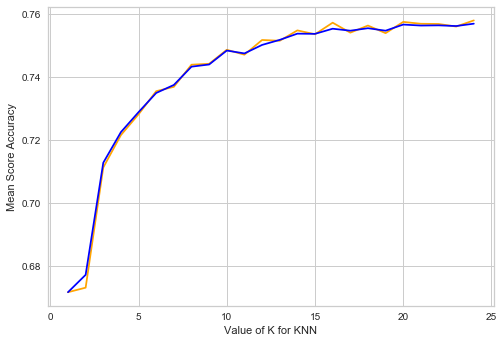

In [92]:
if RUN_OTHER:
    #score_dist = pd.DataFrame(grid.cv_results_)['mean_test_score']

    weight_u = pd.DataFrame(grid.cv_results_)[pd.DataFrame(grid.cv_results_)['param_weights'] == 'uniform']#results from uniform parameter weights
    weight_d = pd.DataFrame(grid.cv_results_)[pd.DataFrame(grid.cv_results_)['param_weights'] == 'distance']

    plt.plot(k_range, weight_u['mean_test_score'], color = 'orange')
    plt.plot(k_range, weight_d['mean_test_score'], color = 'blue')
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Mean Score Accuracy')
    plt.legend()

In [93]:
%%time 
if RUN_OTHER:
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import confusion_matrix 

    X = df_arrest_small.drop(['Arrest Type Code'], axis = 1) #data
    y = df_arrest_small['Arrest Type Code'] #target

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1234)

    knn = KNeighborsClassifier(n_neighbors = 24, weights = 'uniform').fit(X_train, y_train) 

    # accuracy on X_test 
    accuracy = knn.score(X_test, y_test) 
    print("accuracy  = ", accuracy) 

    # creating a confusion matrix 
    knn_predictions = knn.predict(X_test)  
    cm = confusion_matrix(y_test, knn_predictions) 
    print("confusion matrix \n", cm)

    from sklearn.metrics import precision_recall_fscore_support
    a = precision_recall_fscore_support(y_test, knn_predictions, average='micro')
    b = precision_recall_fscore_support(y_test, knn_predictions, average='weighted')

    print('micro average precision/recall/fscore = ', a)

    print('\nweighted average precision/recall/fscore = ', b)


accuracy  =  0.7628711010898158
confusion matrix 
 [[1517  952    0    2]
 [ 454 4530   15    0]
 [  12  296   43    0]
 [  36  126    0    0]]
micro average precision/recall/fscore =  (0.7628711010898158, 0.7628711010898158, 0.7628711010898158, None)

weighted average precision/recall/fscore =  (0.7456413161270123, 0.7628711010898158, 0.7387582108409431, None)
Wall time: 49.9 s


76% accuracy is adequate for the purpose of demonstration. Additional test runs on the next highest ranked Grid search recommended parameters scored slightly lower, around 74%, but were omitted for brevity's sake. Grid Search iterating on the possible parameters appears to be at the more efficient than doing so manually. Limitations include computational time limits on longer classifiers like KNN due to the large number of parameters to run, even on a sample of the data. 

### Grid Search for KNN classifier (Descent Code)

In [94]:
%%time
if RUN_OTHER:
    #sampling data for time constraints
    df_descent_small = pd.DataFrame.sample(df_descent, frac = .005, random_state = 1234)
    len(df_descent_small)

Wall time: 42.9 ms


6386

In [95]:
%%time
if RUN_OTHER:
    from sklearn.model_selection import RandomizedSearchCV 

    knn = KNeighborsClassifier(n_neighbors=24, weights='uniform')

    k_range = list(range(1, 31))
    param_grid = dict(n_neighbors = k_range)

    y = df_descent_small['Descent Code'] #target
    X = df_descent_small.drop(['Descent Code'], axis = 1) #data


    #Randomized search CV grid search
    k_range = list(range(1, 25))
    weight_options = ['uniform', 'distance']

    param_grid = dict(n_neighbors = k_range, weights = weight_options)

    rand = RandomizedSearchCV(knn, param_grid, cv=10, scoring='accuracy', n_iter=10, random_state=5)

    rand.fit(X, y)

    results = pd.DataFrame(rand.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
    results.sort_values(by = ["mean_test_score"], ascending = False)

Wall time: 38.2 s


mean_test_score  std_test_score                                      params
9         0.511431        0.020660  {'weights': 'distance', 'n_neighbors': 23}
7         0.507360        0.021876   {'weights': 'uniform', 'n_neighbors': 22}
0         0.506420        0.021897  {'weights': 'distance', 'n_neighbors': 15}
1         0.500783        0.022446   {'weights': 'uniform', 'n_neighbors': 17}
5         0.498434        0.024814   {'weights': 'uniform', 'n_neighbors': 14}
3         0.495615        0.022529   {'weights': 'distance', 'n_neighbors': 9}
4         0.494989        0.023966  {'weights': 'distance', 'n_neighbors': 10}
2         0.460069        0.027691    {'weights': 'uniform', 'n_neighbors': 4}
6         0.421391        0.022662    {'weights': 'uniform', 'n_neighbors': 2}
8         0.416536        0.027111   {'weights': 'distance', 'n_neighbors': 2}

No handles with labels found to put in legend.


Wall time: 19.9 ms


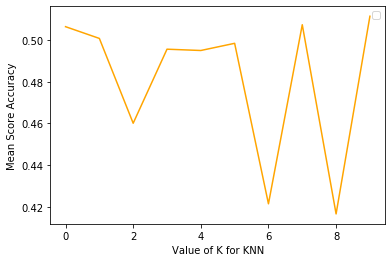

In [96]:
%%time
if RUN_OTHER:
    #results by weight type

    weight_u = pd.DataFrame(rand.cv_results_)[pd.DataFrame(rand.cv_results_)['param_weights'] == 'uniform']#results from uniform parameter weights
    weight_d = pd.DataFrame(rand.cv_results_)[pd.DataFrame(rand.cv_results_)['param_weights'] == 'distance']


    plt.plot( pd.DataFrame(rand.cv_results_)['mean_test_score'], color = 'orange')
    #plt.plot(k_range, weight_d['mean_test_score'], color = 'blue')
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Mean Score Accuracy')
    plt.legend()

In [97]:
%%time 
if RUN_OTHER:
    #implementing grid search selected classifier parameters
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import confusion_matrix 

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1234)

    knn = KNeighborsClassifier(n_neighbors = 23, weights = 'uniform').fit(X_train, y_train) 

    # accuracy on X_test 
    accuracy = knn.score(X_test, y_test) 
    print("accuracy  = ", accuracy) 

    # creating a confusion matrix 
    knn_predictions = knn.predict(X_test)  
    cm = confusion_matrix(y_test, knn_predictions) 
    print("confusion matrix \n", cm)

    from sklearn.metrics import precision_recall_fscore_support
    a = precision_recall_fscore_support(y_test, knn_predictions, average='micro')
    b = precision_recall_fscore_support(y_test, knn_predictions, average='weighted')

    print('micro average precision/recall/fscore = ', a)

    print('\nweighted average precision/recall/fscore = ', b)


accuracy  =  0.5128365685660614
confusion matrix 
 [[212 208  24   0]
 [136 567  33   0]
 [105 178  40   0]
 [ 16  69   9   0]]
micro average precision/recall/fscore =  (0.5128365685660614, 0.5128365685660614, 0.5128365685660614, None)

weighted average precision/recall/fscore =  (0.4576799749012331, 0.5128365685660614, 0.4641112968558727, None)
Wall time: 1.76 s


Randomized Search CV drastically cuts down computational time, but doesn't make quite as clean a picture as running through every possible permutation. The lower accuracy be attributed to both the random nature of the classifier parameters that were explored and the multicategorical nature of classifying the four possible descent codes. 